## Environment set up and import Libraries

In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  print(device_name.split(":")[1]," running . . . ")

GPU  running . . . 


2022-09-16 07:20:47.030465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 07:20:47.031308: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 07:20:47.031776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 07:20:47.032193: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 07:20:47.032513: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [37]:
import tensorflow as tf
import os,sys
import numpy as np
import random

random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [38]:
import os, keras, numpy,tensorflow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from numpy import *
from numpy.random import *
from keras.datasets.fashion_mnist import load_data
from keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import *
from tensorflow.keras import initializers

## **Discriminator** Model

In [39]:
def define_discriminator(in_shape=(64,64,3),n_classes=5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 150)(label_layer_1)
    label_layer_3 = Dense(in_shape[0] * in_shape[1])(label_layer_2)
    label_layer_4 = Reshape((in_shape[0], in_shape[1], 1))(label_layer_3)
    # (64, 64, 1)

    # input image
    input_image = Input(shape=in_shape, name = "input_image")
    # (64, 64, 3)

    concat_layer = Concatenate()([input_image, label_layer_4])
    # (64, 64, 4)

    conv2d_layer_2 = Conv2D(filters = 64, kernel_size = (3,3), strides = (2,2), padding = 'same')(concat_layer)
    conv2d_layer_2 = LeakyReLU(alpha=0.4)(conv2d_layer_2)
    # (32, 32, 64)

    label_layer_2_1 = Embedding(n_classes, 150)(label_layer_1)
    label_layer_3_1 = Dense(32 * 32)(label_layer_2_1)
    label_layer_4_1 = Reshape((32, 32, 1))(label_layer_3_1)
    # (32, 32, 1)

    concat_layer_1 = Concatenate()([conv2d_layer_2, label_layer_4_1])
    # (32, 32, 65)

    conv2d_layer_3 = Conv2D(filters = 128, kernel_size = (3,3),  strides = (2,2), padding = 'same')(concat_layer_1)
    conv2d_layer_3 = LeakyReLU(alpha=0.4)(conv2d_layer_3)
    # (16, 16, 128)

    conv2d_layer_4 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_3)
    conv2d_layer_4 = LeakyReLU(alpha=0.4)(conv2d_layer_4)
    # (8, 8, 128)

    conv2d_layer_5 = Conv2D(filters = 128, kernel_size = (3,3), strides = (2,2), padding = 'same')(conv2d_layer_4)
    conv2d_layer_5 = LeakyReLU(alpha=0.4)(conv2d_layer_5)
    # (4, 4, 128)

    flatten_layer = Flatten()(conv2d_layer_5)
    # (4 * 4 * 128)

    dropout_layer = Dropout(rate=0.4)(flatten_layer)
    # (4 * 4 * 128)

    dense_layer = Dense(128 * 8 * 2, activation='relu')(dropout_layer)
    # (8 * 128 * 2)

    # final layer
    output_layer = Dense(1, activation='linear')(dense_layer)
    # (1,)

    model = Model([input_image,label_layer_1], output_layer)

    opt = Adam(learning_rate= 3e-4, beta_1=0.5)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

a = define_discriminator()
a.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_label (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 1, 150)       750         input_label[0][0]                
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 1, 4096)      618496      embedding_9[0][0]                
__________________________________________________________________________________________________
input_image (InputLayer)        [(None, 64, 64, 3)]  0                                            
____________________________________________________________________________________________

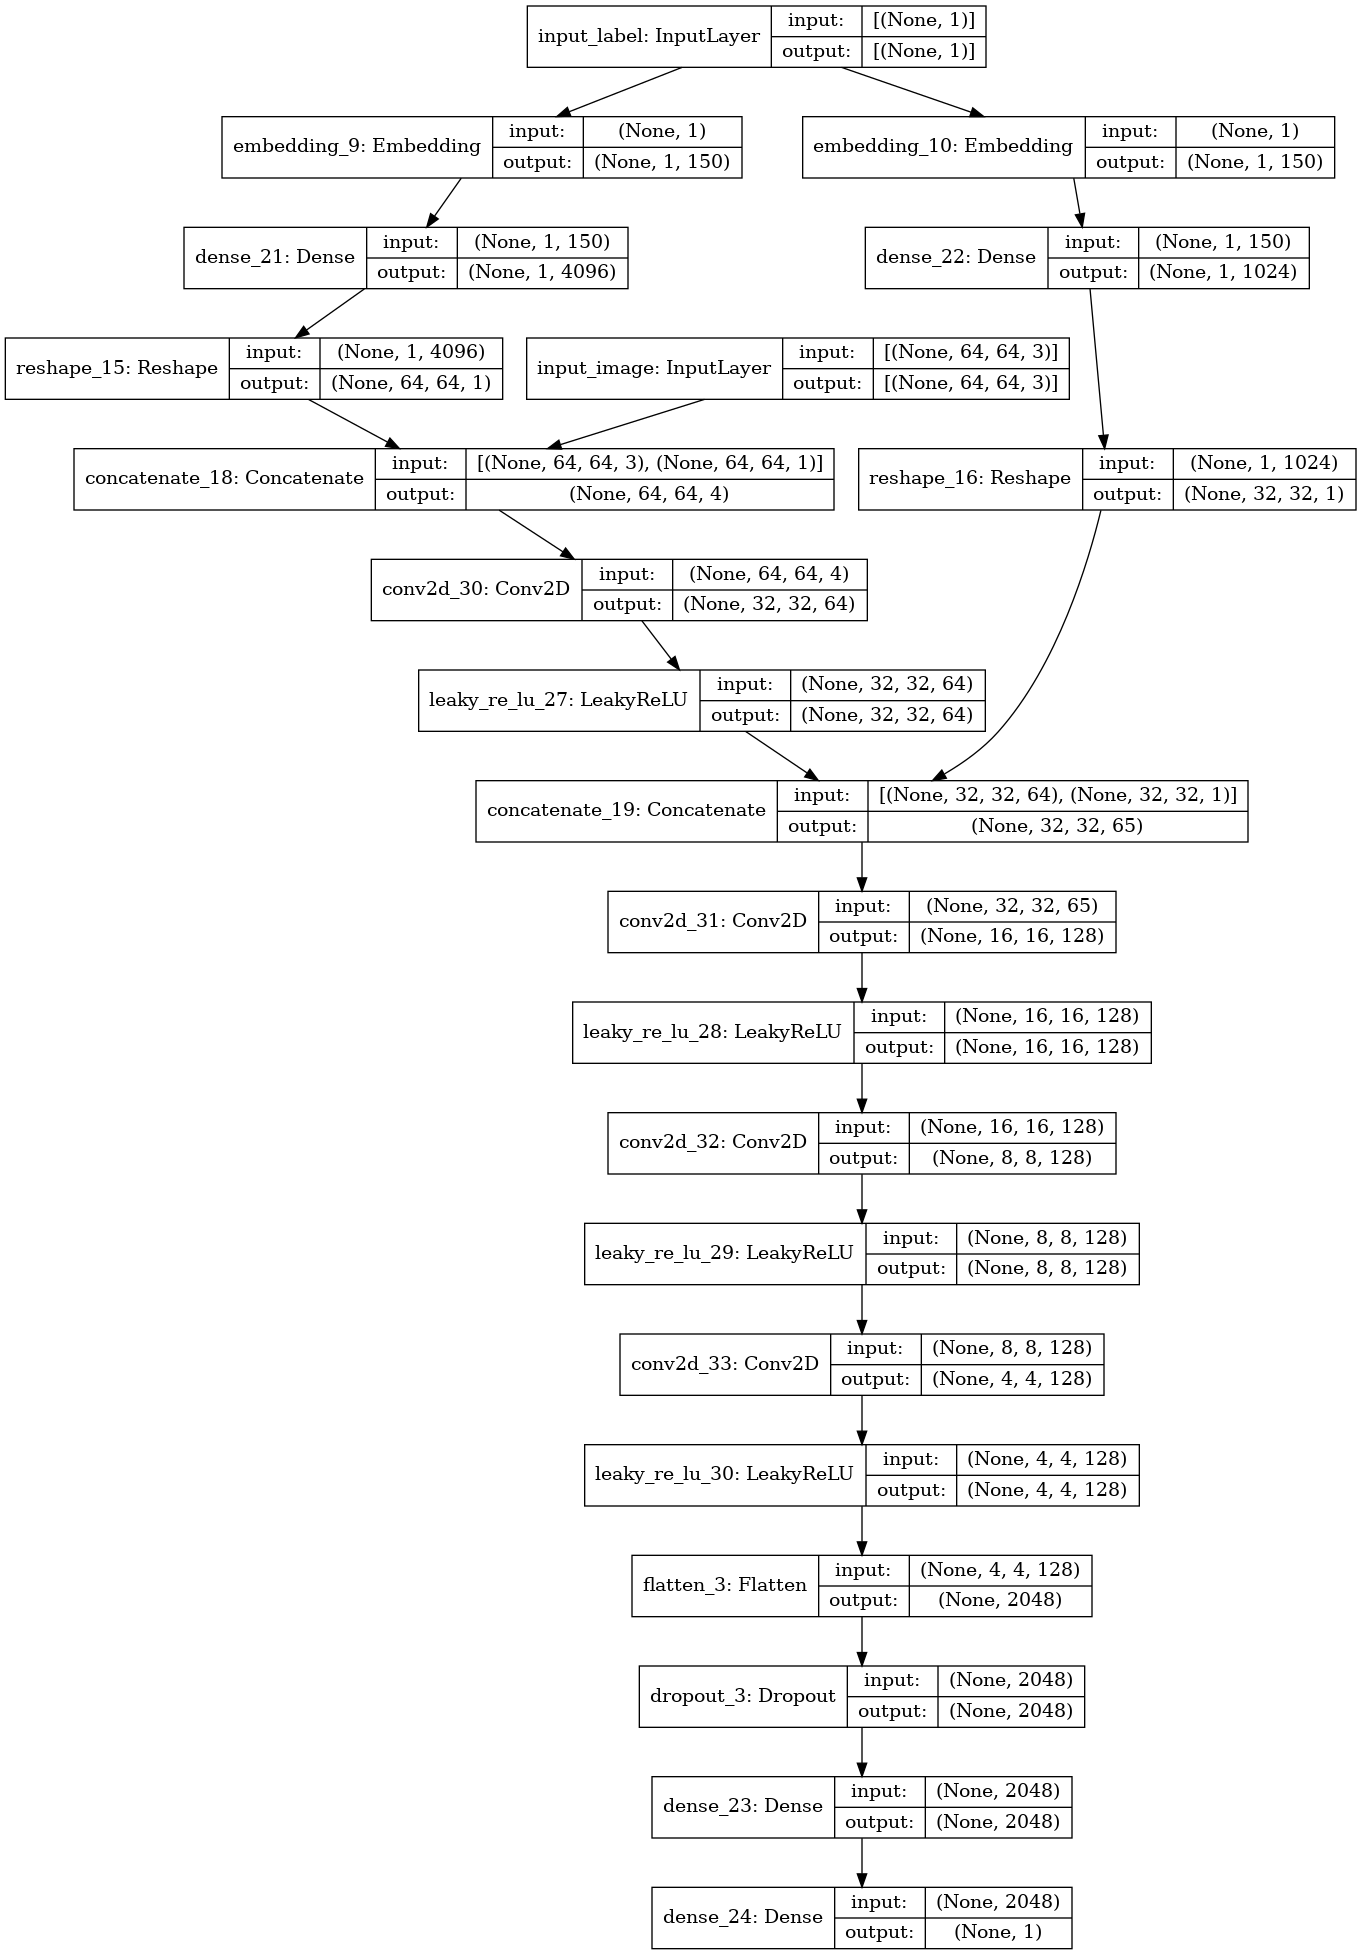

In [40]:
# plot the discriminator model
tf.keras.utils.plot_model(a,to_file='discriminator.png',show_shapes=True,show_layer_names=True)

## **Generator** Model

In [41]:
def define_generator(latent_dim = 100, n_classes = 5):

    # input level
    label_layer_1 = Input(shape=(1,), name = "input_label")
    label_layer_2 = Embedding(n_classes, 150)(label_layer_1)
    label_layer_3 = Dense(8 * 8)(label_layer_2)
    label_layer_4 = Reshape((8, 8, 1))(label_layer_3)
    # (8, 8, 1)

    # latent input
    latent_layer = Input(shape=(latent_dim,), name = "input_latent")

    layer_2 = Dense(128 * 8 * 8)(latent_layer)
    layer_2 = Activation("relu")(layer_2)
    layer_2 = Reshape((8, 8, 128))(layer_2)
    # (8, 8, 128)


    concat_layer_1 = Concatenate()([layer_2, label_layer_4])
    # (8, 8, 129)

    layer_3 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_1)
    layer_3 = Conv2D(filters = 64, kernel_size = (3,3), padding='same', kernel_initializer = initializers.RandomNormal(0,0.8))(layer_3)
    layer_3 = BatchNormalization(momentum = 0.8)(layer_3)
    layer_3 = LeakyReLU(alpha=0.4)(layer_3)
    # (16, 16, 64)
    
    label_layer_3_1 = Dense(16 * 16)(label_layer_2)
    label_layer_4_1 = Reshape((16, 16, 1))(label_layer_3_1)
    # 16, 16, 1)

    concat_layer_2 = Concatenate()([layer_3, label_layer_4_1])
    # (16, 16, 65)

    layer_4 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_2)
    layer_4 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4 = BatchNormalization(momentum = 0.8)(layer_4)
    layer_4 = LeakyReLU(alpha=0.4)(layer_4)
    # (32, 32, 64)
    
    layer_4_1 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_4)
    layer_4_1 = BatchNormalization(momentum = 0.8)(layer_4_1)
    layer_4_1 = LeakyReLU(alpha=0.4)(layer_4_1)
    # (32, 32, 64)

    concat_layer_2 = Concatenate()([layer_4, layer_4_1])
    # (32, 32, 128)


    layer_5 = Conv2DTranspose(filters = 64, kernel_size = (3,3), strides=(2,2), padding='same')(concat_layer_2)
    layer_5 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_5 = BatchNormalization(momentum = 0.8)(layer_5)
    layer_5 = LeakyReLU(alpha=0.4)(layer_5)
    # (64, 64, 64)

    layer_6 = Conv2D(filters = 64, kernel_size = (3,3), padding='same',kernel_initializer = initializers.RandomNormal(0,0.8))(layer_5)
    layer_6 = BatchNormalization(momentum = 0.8)(layer_6)
    layer_6 = LeakyReLU(alpha=0.4)(layer_6)
    # (64, 64, 64)

    concat_layer_3 = Concatenate()([layer_5, layer_6])
    # (64, 64, 128)

    # final layer
    output_layer = Conv2D(filters = 3, kernel_size = (4,4), strides=(1,1), activation='tanh', padding='same')(concat_layer_3)

    model = Model([latent_layer,label_layer_1], output_layer)
    return model

b = define_generator(512)
b.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_latent (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 8192)         4202496     input_latent[0][0]               
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 150)       750         input_label[0][0]                
___________________________________________________________________________________________

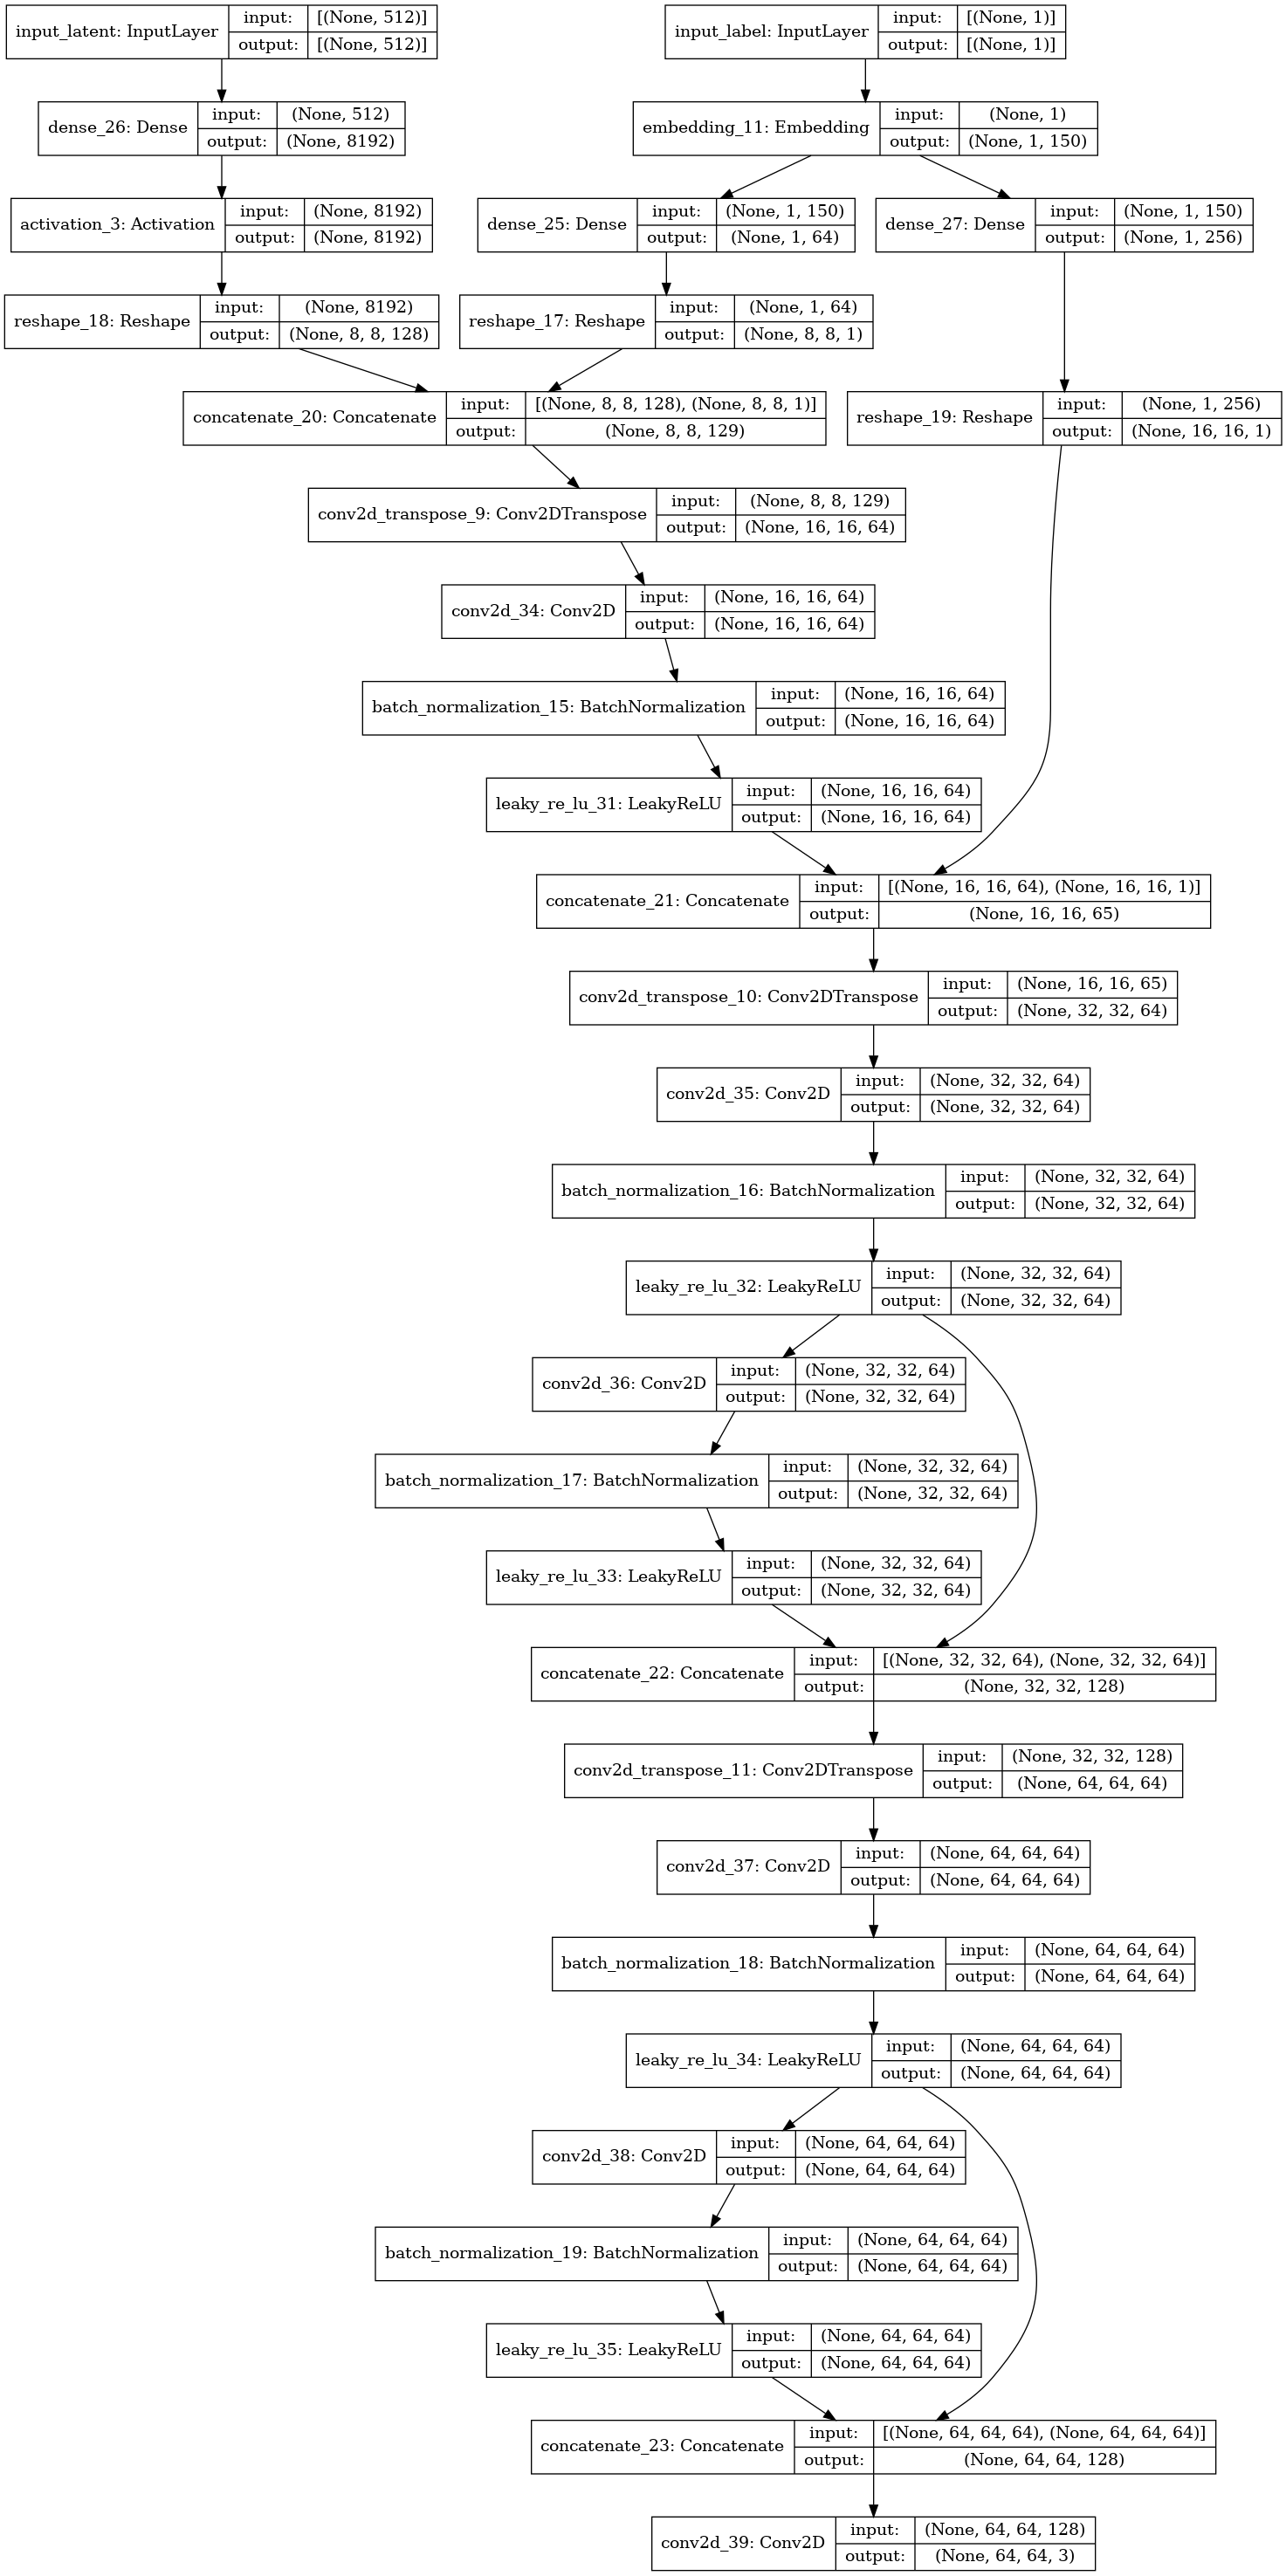

In [42]:
# plot the generator model
tf.keras.utils.plot_model(b,to_file='generator.png',show_shapes=True,show_layer_names=True)

## **Combine** or **GAN** Model

In [43]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  g_latent, g_label = g_model.input
  g_output = g_model.output

  d_output = d_model([g_output,g_label])

  model = Model([g_latent, g_label], d_output)

  opt = Adam(learning_rate= 3e-4, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt,  metrics=['accuracy'])
  
  return model
c = define_gan(b, a)
c.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_latent (InputLayer)       [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 8192)         4202496     input_latent[0][0]               
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 1, 150)       750         input_label[0][0]                
___________________________________________________________________________________________

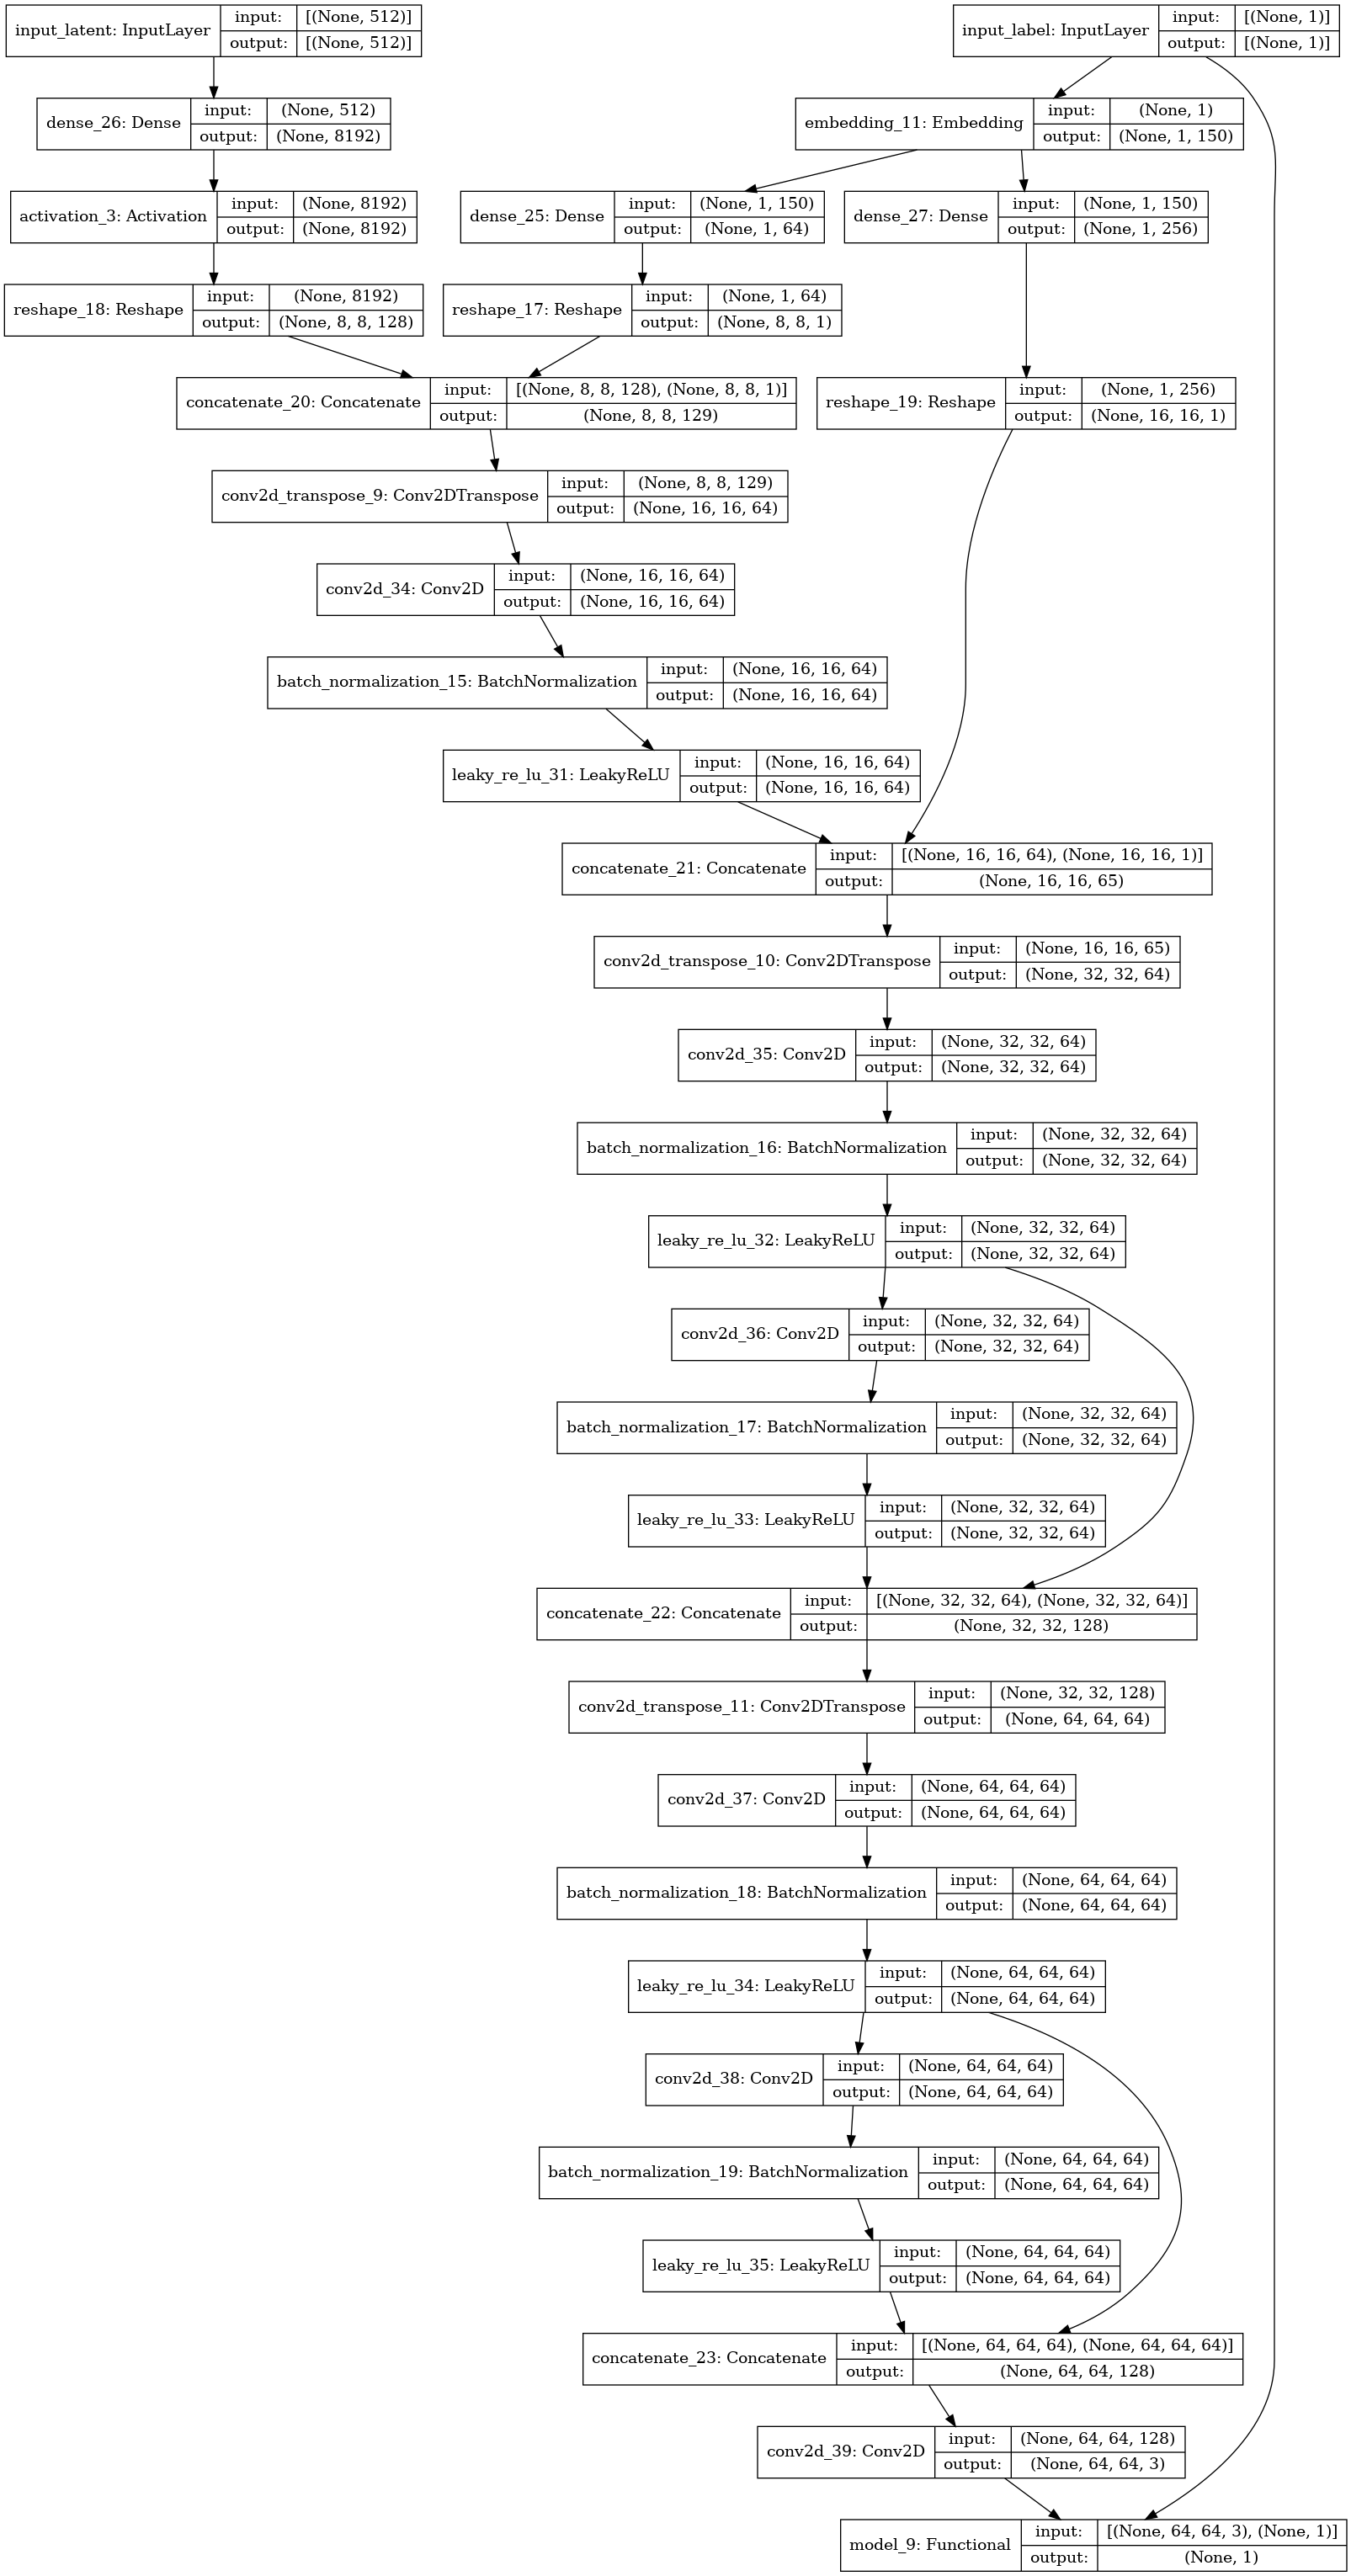

In [44]:
# plot GAN model
tf.keras.utils.plot_model(c,to_file='complete_gan.png',show_shapes=True,show_layer_names=True)

## Load Dataset

In [45]:
def load_real_samples():
  # load dataset
  data = np.load("../input/flower242-64/RGB_64_64_3.npz")
  data = data['a']
  data = np.array(data)
  shuffle(data)
  X = data.astype('float32')
  # scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
k = load_real_samples()
print("image: ",k.shape)
print("\nshape/size of the first 16 data: ",k[:16].shape)

image:  (8189, 64, 64, 3)

shape/size of the first 16 data:  (16, 64, 64, 3)


## Plot data with label

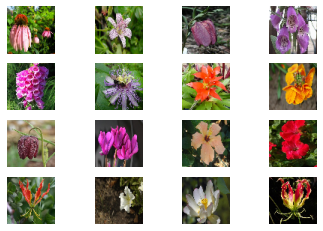

In [46]:
def save_plot(x_input,a,n=4):
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
#     plt.suptitle("Epoch_"+str(a))
#     plt.savefig("/content/drive/MyDrive/Flower_LSGAN/1/epoch_"+str(a))
    plt.show()
# plot data
save_plot((k[:16]+1)/2.0,0)

## Generate real sample function

In [47]:
def generate_real_samples(dataset, n_samples):
	images = dataset
	ix = randint(0, images.shape[0], n_samples)
	X = images[ix]
	z = np.random.randint(0,5,size=(n_samples))
	y = ones((n_samples, 1))
	return [X,z], y
# d = generate_real_samples(k, 32)
# print("Generate real data as a batch randomly: ",d[0][0].shape)

## Generate latent point function

In [48]:
def generate_latent_points(latent_dim, n_samples):
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  z = np.random.randint(0,5,size=(n_samples))
  return [z_input,z]
# p = generate_latent_points(512, 32)
# print("Generate latent point(with label) as a batch: ",p[0].shape)

## Generate Fake samples of image with label

In [49]:
def generate_fake_samples(generator, latent_dim, n_samples):
	z_input,z = generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input,z])
	y = zeros((n_samples, 1))
	return [images, z], y
# with tf.device(device_name):
	# kh = generate_fake_samples(b, 512, 32)
	# print("shape of the generated images: ",kh[0][0].shape)

## Summarize the generator model

In [50]:
def summarize_the_model(generator, count, latent_dim = 100):
    latent_points = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict(latent_points)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    save_plot(X, count, n=4)

In [51]:
def save_figure(generator,a,latent_dim = 512,n=4):
    latent_points, labels = generate_latent_points(latent_dim= latent_dim, n_samples= 16)
    X  = generator.predict([latent_points, labels])
    # plt.title("Epoch_"+str(a+1),loc = "center")
    for j in range(n*n):
        plt.subplot(n, n, j+1)
        plt.imshow(X[j,:,:,:])
        plt.axis('off')
#     plt.suptitle("Epoch_"+str(a+1))
    # plt.savefig("/content/drive/MyDrive/GAN_New_Approch/4/epoch_"+str(a+1))

## Train function

In [52]:
def train(g_model, d_model, gan_model, dataset, latent_dim= 100, n_epochs=3, n_batch=128):

  print("No. of epoch: ",n_epochs)
  bat_per_epo = int(dataset.shape[0] / n_batch)
  print("Data Size: ",dataset.shape[0])
  print("batch per epoch: ", bat_per_epo)
  print("full batch: ",n_batch)
  half_batch = int(n_batch / 2)
  print("half batch: ", half_batch,'\n')
  print("*"*50,'\n\n')

  d_loss_real_array,d_loss_fake_array =[],[]
  g_loss_array = []
    
  count = 1
  for i in range(n_epochs):
    d_loss_r,d_loss_f = 0.0,0.0
    g_loss = 0.0
    
    for j in range(bat_per_epo):

      [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
      d_loss_r += (d_loss1 / half_batch)
      # print("real_loss")

      [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
      d_loss_f += (d_loss2 / half_batch)
      # print("fake_loss")

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = ones((n_batch, 1))
      g_loss1,_ = gan_model.train_on_batch([z_input, labels_input], y_gan)
      g_loss += (g_loss1 / n_batch)

    d_loss_real_array.append(d_loss_r/bat_per_epo)
    d_loss_fake_array.append(d_loss_f/bat_per_epo)
    g_loss_array.append(g_loss/bat_per_epo)

    print('epoch -> [%d/%d], discriminator_loss_for_real_data = %f, discriminator_loss_for_fake_data = %f, generator_loss = %f' %(i+1, n_epochs, d_loss_r/bat_per_epo, d_loss_f/bat_per_epo, g_loss/bat_per_epo))
    if((i+1)%20==0):
        summarize_the_model(g_model,count,latent_dim)
        count = count + 1
    g_model.save("generator_model.h5")
    np.savez_compressed('loss_record.npz', a=d_loss_real_array, b=d_loss_fake_array, c=g_loss_array)
    # save_figure(g_model,i,latent_dim = 512,n=4)

    print("\n")

  return d_loss_real_array, d_loss_fake_array, g_loss_array

## Main function


READY TO GO !!!

No. of epoch:  600
Data Size:  8189
batch per epoch:  204
full batch:  40
half batch:  20 

************************************************** 


epoch -> [1/600], discriminator_loss_for_real_data = 0.010124, discriminator_loss_for_fake_data = 0.005451, generator_loss = 0.026776




2022-09-16 07:21:33.532647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [2/600], discriminator_loss_for_real_data = 0.007069, discriminator_loss_for_fake_data = 0.003713, generator_loss = 0.023286




2022-09-16 07:21:56.220655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [3/600], discriminator_loss_for_real_data = 0.009922, discriminator_loss_for_fake_data = 0.006270, generator_loss = 0.023300


epoch -> [4/600], discriminator_loss_for_real_data = 0.009430, discriminator_loss_for_fake_data = 0.007273, generator_loss = 0.020270


epoch -> [5/600], discriminator_loss_for_real_data = 0.006992, discriminator_loss_for_fake_data = 0.004623, generator_loss = 0.024181


epoch -> [6/600], discriminator_loss_for_real_data = 0.006295, discriminator_loss_for_fake_data = 0.004084, generator_loss = 0.025091




2022-09-16 07:23:32.086856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [7/600], discriminator_loss_for_real_data = 0.007030, discriminator_loss_for_fake_data = 0.005262, generator_loss = 0.024260




2022-09-16 07:24:03.323175: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [8/600], discriminator_loss_for_real_data = 0.008828, discriminator_loss_for_fake_data = 0.006316, generator_loss = 0.021475




2022-09-16 07:24:18.471237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [9/600], discriminator_loss_for_real_data = 0.007691, discriminator_loss_for_fake_data = 0.005195, generator_loss = 0.022896


epoch -> [10/600], discriminator_loss_for_real_data = 0.007848, discriminator_loss_for_fake_data = 0.005322, generator_loss = 0.023309




2022-09-16 07:25:07.273684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:25:13.506783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [11/600], discriminator_loss_for_real_data = 0.007691, discriminator_loss_for_fake_data = 0.005712, generator_loss = 0.022394


epoch -> [12/600], discriminator_loss_for_real_data = 0.007418, discriminator_loss_for_fake_data = 0.005501, generator_loss = 0.023279


epoch -> [13/600], discriminator_loss_for_real_data = 0.007459, discriminator_loss_for_fake_data = 0.005685, generator_loss = 0.023239


epoch -> [14/600], discriminator_loss_for_real_data = 0.007322, discriminator_loss_for_fake_data = 0.005374, generator_loss = 0.023053


epoch -> [15/600], discriminator_loss_for_real_data = 0.006642, discriminator_loss_for_fake_data = 0.004823, generator_loss = 0.023403




2022-09-16 07:27:13.956076: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:27:28.715351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [16/600], discriminator_loss_for_real_data = 0.006811, discriminator_loss_for_fake_data = 0.005059, generator_loss = 0.023009


epoch -> [17/600], discriminator_loss_for_real_data = 0.006863, discriminator_loss_for_fake_data = 0.005014, generator_loss = 0.022598




2022-09-16 07:28:17.360642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:28:17.962847: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [18/600], discriminator_loss_for_real_data = 0.006530, discriminator_loss_for_fake_data = 0.004630, generator_loss = 0.023025




2022-09-16 07:28:48.960436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:28:49.712465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [19/600], discriminator_loss_for_real_data = 0.006441, discriminator_loss_for_fake_data = 0.004898, generator_loss = 0.022552


epoch -> [20/600], discriminator_loss_for_real_data = 0.006232, discriminator_loss_for_fake_data = 0.004810, generator_loss = 0.022912


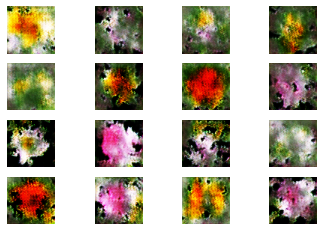



epoch -> [21/600], discriminator_loss_for_real_data = 0.005952, discriminator_loss_for_fake_data = 0.004256, generator_loss = 0.023167


epoch -> [22/600], discriminator_loss_for_real_data = 0.006496, discriminator_loss_for_fake_data = 0.005002, generator_loss = 0.022979




2022-09-16 07:30:24.833750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:30:24.986708: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [23/600], discriminator_loss_for_real_data = 0.006028, discriminator_loss_for_fake_data = 0.004409, generator_loss = 0.023179




2022-09-16 07:30:56.587785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:30:56.661512: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:30:56.726770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:30:56.954067: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [24/600], discriminator_loss_for_real_data = 0.006186, discriminator_loss_for_fake_data = 0.004664, generator_loss = 0.023243


epoch -> [25/600], discriminator_loss_for_real_data = 0.005720, discriminator_loss_for_fake_data = 0.004296, generator_loss = 0.023736


epoch -> [26/600], discriminator_loss_for_real_data = 0.005694, discriminator_loss_for_fake_data = 0.004263, generator_loss = 0.023378


epoch -> [27/600], discriminator_loss_for_real_data = 0.005880, discriminator_loss_for_fake_data = 0.004354, generator_loss = 0.023285


epoch -> [28/600], discriminator_loss_for_real_data = 0.005656, discriminator_loss_for_fake_data = 0.004091, generator_loss = 0.022772


epoch -> [29/600], discriminator_loss_for_real_data = 0.006174, discriminator_loss_for_fake_data = 0.004698, generator_loss = 0.022410




2022-09-16 07:33:02.942350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [30/600], discriminator_loss_for_real_data = 0.005907, discriminator_loss_for_fake_data = 0.004332, generator_loss = 0.021986




2022-09-16 07:33:39.142201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [31/600], discriminator_loss_for_real_data = 0.006123, discriminator_loss_for_fake_data = 0.004359, generator_loss = 0.022273


epoch -> [32/600], discriminator_loss_for_real_data = 0.005961, discriminator_loss_for_fake_data = 0.004379, generator_loss = 0.021768


epoch -> [33/600], discriminator_loss_for_real_data = 0.005330, discriminator_loss_for_fake_data = 0.003995, generator_loss = 0.022755


epoch -> [34/600], discriminator_loss_for_real_data = 0.005710, discriminator_loss_for_fake_data = 0.004185, generator_loss = 0.022493


epoch -> [35/600], discriminator_loss_for_real_data = 0.005316, discriminator_loss_for_fake_data = 0.003734, generator_loss = 0.022857


epoch -> [36/600], discriminator_loss_for_real_data = 0.005147, discriminator_loss_for_fake_data = 0.003763, generator_loss = 0.022621


epoch -> [37/600], discriminator_loss_for_real_data = 0.005380, discriminator_loss_for_fake_data = 0.003907, generator_loss = 0.022320




2022-09-16 07:36:35.401770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [38/600], discriminator_loss_for_real_data = 0.004891, discriminator_loss_for_fake_data = 0.003482, generator_loss = 0.022801


epoch -> [39/600], discriminator_loss_for_real_data = 0.005065, discriminator_loss_for_fake_data = 0.003884, generator_loss = 0.022843


epoch -> [40/600], discriminator_loss_for_real_data = 0.004913, discriminator_loss_for_fake_data = 0.003544, generator_loss = 0.023011


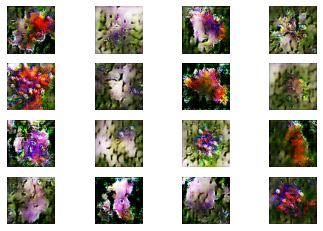

2022-09-16 07:37:41.355404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [41/600], discriminator_loss_for_real_data = 0.004991, discriminator_loss_for_fake_data = 0.003676, generator_loss = 0.023002




2022-09-16 07:38:20.703016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:38:21.476903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [42/600], discriminator_loss_for_real_data = 0.004905, discriminator_loss_for_fake_data = 0.003337, generator_loss = 0.023128




2022-09-16 07:38:52.458985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [43/600], discriminator_loss_for_real_data = 0.004872, discriminator_loss_for_fake_data = 0.003482, generator_loss = 0.023276


epoch -> [44/600], discriminator_loss_for_real_data = 0.004561, discriminator_loss_for_fake_data = 0.003452, generator_loss = 0.023696


epoch -> [45/600], discriminator_loss_for_real_data = 0.004657, discriminator_loss_for_fake_data = 0.003454, generator_loss = 0.023204


epoch -> [46/600], discriminator_loss_for_real_data = 0.004658, discriminator_loss_for_fake_data = 0.003473, generator_loss = 0.022941


epoch -> [47/600], discriminator_loss_for_real_data = 0.004657, discriminator_loss_for_fake_data = 0.003374, generator_loss = 0.022936


epoch -> [48/600], discriminator_loss_for_real_data = 0.005779, discriminator_loss_for_fake_data = 0.003986, generator_loss = 0.022738


epoch -> [49/600], discriminator_loss_for_real_data = 0.004557, discriminator_loss_for_fake_data = 0.003397, generator_loss = 0.022721


epoch -> [50/600], discriminator_loss_for

2022-09-16 07:42:03.502710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:42:03.643692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [51/600], discriminator_loss_for_real_data = 0.004541, discriminator_loss_for_fake_data = 0.003206, generator_loss = 0.022807




2022-09-16 07:42:35.448428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [52/600], discriminator_loss_for_real_data = 0.004333, discriminator_loss_for_fake_data = 0.003215, generator_loss = 0.023312




2022-09-16 07:42:38.250172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:43:00.272787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [53/600], discriminator_loss_for_real_data = 0.004467, discriminator_loss_for_fake_data = 0.003297, generator_loss = 0.023092


epoch -> [54/600], discriminator_loss_for_real_data = 0.004367, discriminator_loss_for_fake_data = 0.003300, generator_loss = 0.022925




2022-09-16 07:43:38.788968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [55/600], discriminator_loss_for_real_data = 0.004371, discriminator_loss_for_fake_data = 0.003043, generator_loss = 0.022965




2022-09-16 07:44:17.119943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [56/600], discriminator_loss_for_real_data = 0.004458, discriminator_loss_for_fake_data = 0.003173, generator_loss = 0.023170


epoch -> [57/600], discriminator_loss_for_real_data = 0.004092, discriminator_loss_for_fake_data = 0.002962, generator_loss = 0.023012


epoch -> [58/600], discriminator_loss_for_real_data = 0.004557, discriminator_loss_for_fake_data = 0.003336, generator_loss = 0.022869




2022-09-16 07:45:14.392585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [59/600], discriminator_loss_for_real_data = 0.004489, discriminator_loss_for_fake_data = 0.003080, generator_loss = 0.022654


epoch -> [60/600], discriminator_loss_for_real_data = 0.004213, discriminator_loss_for_fake_data = 0.002971, generator_loss = 0.022624


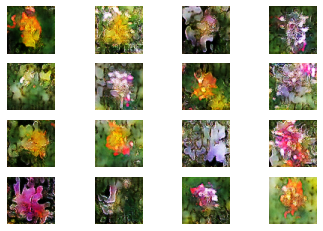



epoch -> [61/600], discriminator_loss_for_real_data = 0.004343, discriminator_loss_for_fake_data = 0.003057, generator_loss = 0.022519


epoch -> [62/600], discriminator_loss_for_real_data = 0.004238, discriminator_loss_for_fake_data = 0.003001, generator_loss = 0.022519




2022-09-16 07:46:48.935445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:46:49.324019: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [63/600], discriminator_loss_for_real_data = 0.004376, discriminator_loss_for_fake_data = 0.003194, generator_loss = 0.022590




2022-09-16 07:47:20.685439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:47:20.991861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [64/600], discriminator_loss_for_real_data = 0.004212, discriminator_loss_for_fake_data = 0.002864, generator_loss = 0.022676




2022-09-16 07:47:52.467133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:47:52.804822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:47:57.638234: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [65/600], discriminator_loss_for_real_data = 0.004414, discriminator_loss_for_fake_data = 0.003157, generator_loss = 0.022354




2022-09-16 07:48:08.231134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [66/600], discriminator_loss_for_real_data = 0.004428, discriminator_loss_for_fake_data = 0.003084, generator_loss = 0.022295


epoch -> [67/600], discriminator_loss_for_real_data = 0.004159, discriminator_loss_for_fake_data = 0.002973, generator_loss = 0.022637




2022-09-16 07:48:56.380368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:49:03.629776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [68/600], discriminator_loss_for_real_data = 0.004288, discriminator_loss_for_fake_data = 0.002976, generator_loss = 0.022632




2022-09-16 07:49:28.253771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [69/600], discriminator_loss_for_real_data = 0.004226, discriminator_loss_for_fake_data = 0.002983, generator_loss = 0.022361




2022-09-16 07:49:59.194683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [70/600], discriminator_loss_for_real_data = 0.004224, discriminator_loss_for_fake_data = 0.003089, generator_loss = 0.022627


epoch -> [71/600], discriminator_loss_for_real_data = 0.004038, discriminator_loss_for_fake_data = 0.002854, generator_loss = 0.022698


epoch -> [72/600], discriminator_loss_for_real_data = 0.004740, discriminator_loss_for_fake_data = 0.003270, generator_loss = 0.021991




2022-09-16 07:51:03.291729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:51:03.801458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [73/600], discriminator_loss_for_real_data = 0.004891, discriminator_loss_for_fake_data = 0.003369, generator_loss = 0.021610




2022-09-16 07:51:35.466035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:51:35.609035: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [74/600], discriminator_loss_for_real_data = 0.004342, discriminator_loss_for_fake_data = 0.003000, generator_loss = 0.021978




2022-09-16 07:52:06.809071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:52:07.234812: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [75/600], discriminator_loss_for_real_data = 0.004648, discriminator_loss_for_fake_data = 0.003053, generator_loss = 0.022056




2022-09-16 07:52:32.233381: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:52:38.791718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [76/600], discriminator_loss_for_real_data = 0.004505, discriminator_loss_for_fake_data = 0.003054, generator_loss = 0.021955




2022-09-16 07:52:43.451075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [77/600], discriminator_loss_for_real_data = 0.004449, discriminator_loss_for_fake_data = 0.003125, generator_loss = 0.021423




2022-09-16 07:53:10.392098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:53:10.685726: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [78/600], discriminator_loss_for_real_data = 0.004608, discriminator_loss_for_fake_data = 0.003062, generator_loss = 0.021312




2022-09-16 07:53:42.318821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:53:42.523766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [79/600], discriminator_loss_for_real_data = 0.004463, discriminator_loss_for_fake_data = 0.003005, generator_loss = 0.021735




2022-09-16 07:54:14.230624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [80/600], discriminator_loss_for_real_data = 0.004265, discriminator_loss_for_fake_data = 0.002876, generator_loss = 0.021817


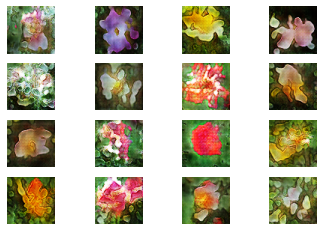

2022-09-16 07:54:22.536202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:54:22.625963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:54:33.406856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [81/600], discriminator_loss_for_real_data = 0.004354, discriminator_loss_for_fake_data = 0.002791, generator_loss = 0.021685


epoch -> [82/600], discriminator_loss_for_real_data = 0.004415, discriminator_loss_for_fake_data = 0.003010, generator_loss = 0.021463




2022-09-16 07:55:16.943034: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [83/600], discriminator_loss_for_real_data = 0.004732, discriminator_loss_for_fake_data = 0.003038, generator_loss = 0.021544




2022-09-16 07:55:49.516122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [84/600], discriminator_loss_for_real_data = 0.004739, discriminator_loss_for_fake_data = 0.003009, generator_loss = 0.021203




2022-09-16 07:56:21.043701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [85/600], discriminator_loss_for_real_data = 0.004681, discriminator_loss_for_fake_data = 0.003099, generator_loss = 0.021370


epoch -> [86/600], discriminator_loss_for_real_data = 0.004773, discriminator_loss_for_fake_data = 0.003133, generator_loss = 0.021275




2022-09-16 07:56:52.219833: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:56:53.009828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [87/600], discriminator_loss_for_real_data = 0.004452, discriminator_loss_for_fake_data = 0.002906, generator_loss = 0.021188




2022-09-16 07:57:24.608024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [88/600], discriminator_loss_for_real_data = 0.004969, discriminator_loss_for_fake_data = 0.003120, generator_loss = 0.021381


epoch -> [89/600], discriminator_loss_for_real_data = 0.004497, discriminator_loss_for_fake_data = 0.002802, generator_loss = 0.021829




2022-09-16 07:58:24.121749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:58:27.957758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 07:58:28.177642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [90/600], discriminator_loss_for_real_data = 0.004442, discriminator_loss_for_fake_data = 0.002925, generator_loss = 0.021093


epoch -> [91/600], discriminator_loss_for_real_data = 0.004594, discriminator_loss_for_fake_data = 0.002903, generator_loss = 0.021521




2022-09-16 07:58:59.667656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [92/600], discriminator_loss_for_real_data = 0.004514, discriminator_loss_for_fake_data = 0.002812, generator_loss = 0.021594




2022-09-16 07:59:30.842738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [93/600], discriminator_loss_for_real_data = 0.004680, discriminator_loss_for_fake_data = 0.002857, generator_loss = 0.021160


epoch -> [94/600], discriminator_loss_for_real_data = 0.004490, discriminator_loss_for_fake_data = 0.002755, generator_loss = 0.021324




2022-09-16 08:00:25.491867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:00:34.779643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [95/600], discriminator_loss_for_real_data = 0.004759, discriminator_loss_for_fake_data = 0.002855, generator_loss = 0.020854


epoch -> [96/600], discriminator_loss_for_real_data = 0.004617, discriminator_loss_for_fake_data = 0.002895, generator_loss = 0.021092




2022-09-16 08:01:06.593886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:01:15.466727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [97/600], discriminator_loss_for_real_data = 0.004563, discriminator_loss_for_fake_data = 0.002817, generator_loss = 0.020957




2022-09-16 08:01:37.777318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [98/600], discriminator_loss_for_real_data = 0.004566, discriminator_loss_for_fake_data = 0.002846, generator_loss = 0.021169


epoch -> [99/600], discriminator_loss_for_real_data = 0.004483, discriminator_loss_for_fake_data = 0.002778, generator_loss = 0.021497


epoch -> [100/600], discriminator_loss_for_real_data = 0.004349, discriminator_loss_for_fake_data = 0.002726, generator_loss = 0.021139


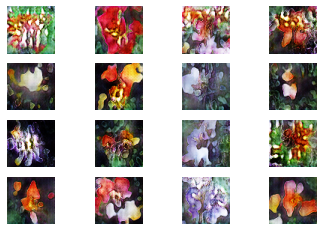

2022-09-16 08:02:41.700989: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [101/600], discriminator_loss_for_real_data = 0.004361, discriminator_loss_for_fake_data = 0.002693, generator_loss = 0.021241




2022-09-16 08:03:13.822749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [102/600], discriminator_loss_for_real_data = 0.004572, discriminator_loss_for_fake_data = 0.002724, generator_loss = 0.020957




2022-09-16 08:03:45.456758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:03:45.521653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:03:54.289835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [103/600], discriminator_loss_for_real_data = 0.004646, discriminator_loss_for_fake_data = 0.002673, generator_loss = 0.020992




2022-09-16 08:04:17.020920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [104/600], discriminator_loss_for_real_data = 0.004603, discriminator_loss_for_fake_data = 0.002612, generator_loss = 0.020903


epoch -> [105/600], discriminator_loss_for_real_data = 0.004329, discriminator_loss_for_fake_data = 0.002530, generator_loss = 0.021376




2022-09-16 08:04:48.821582: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [106/600], discriminator_loss_for_real_data = 0.004585, discriminator_loss_for_fake_data = 0.002673, generator_loss = 0.021286




2022-09-16 08:05:20.958725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:05:33.601269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [107/600], discriminator_loss_for_real_data = 0.004418, discriminator_loss_for_fake_data = 0.002572, generator_loss = 0.021402




2022-09-16 08:05:52.519945: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:05:52.670712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [108/600], discriminator_loss_for_real_data = 0.004558, discriminator_loss_for_fake_data = 0.002558, generator_loss = 0.020902




2022-09-16 08:06:24.252591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [109/600], discriminator_loss_for_real_data = 0.004283, discriminator_loss_for_fake_data = 0.002584, generator_loss = 0.021261


epoch -> [110/600], discriminator_loss_for_real_data = 0.004409, discriminator_loss_for_fake_data = 0.002522, generator_loss = 0.021237


epoch -> [111/600], discriminator_loss_for_real_data = 0.004606, discriminator_loss_for_fake_data = 0.002514, generator_loss = 0.021267


epoch -> [112/600], discriminator_loss_for_real_data = 0.004442, discriminator_loss_for_fake_data = 0.002640, generator_loss = 0.021145




2022-09-16 08:07:59.267767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [113/600], discriminator_loss_for_real_data = 0.004462, discriminator_loss_for_fake_data = 0.002554, generator_loss = 0.021026


epoch -> [114/600], discriminator_loss_for_real_data = 0.004675, discriminator_loss_for_fake_data = 0.002549, generator_loss = 0.020984


epoch -> [115/600], discriminator_loss_for_real_data = 0.004369, discriminator_loss_for_fake_data = 0.002548, generator_loss = 0.021267




2022-09-16 08:09:03.152404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:09:13.433199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [116/600], discriminator_loss_for_real_data = 0.004605, discriminator_loss_for_fake_data = 0.002609, generator_loss = 0.021033


epoch -> [117/600], discriminator_loss_for_real_data = 0.004362, discriminator_loss_for_fake_data = 0.002216, generator_loss = 0.021305




2022-09-16 08:09:57.107029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [118/600], discriminator_loss_for_real_data = 0.004435, discriminator_loss_for_fake_data = 0.002344, generator_loss = 0.020745




2022-09-16 08:10:38.051103: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [119/600], discriminator_loss_for_real_data = 0.004306, discriminator_loss_for_fake_data = 0.002534, generator_loss = 0.021297


epoch -> [120/600], discriminator_loss_for_real_data = 0.004478, discriminator_loss_for_fake_data = 0.002457, generator_loss = 0.020738


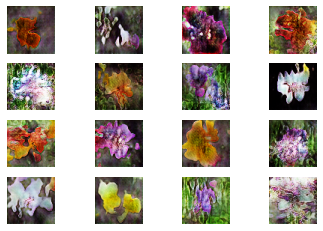

2022-09-16 08:11:09.819722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [121/600], discriminator_loss_for_real_data = 0.004466, discriminator_loss_for_fake_data = 0.002559, generator_loss = 0.020900


epoch -> [122/600], discriminator_loss_for_real_data = 0.004474, discriminator_loss_for_fake_data = 0.002526, generator_loss = 0.020746




2022-09-16 08:11:58.337895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [123/600], discriminator_loss_for_real_data = 0.004451, discriminator_loss_for_fake_data = 0.002465, generator_loss = 0.021142




2022-09-16 08:12:44.835217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [124/600], discriminator_loss_for_real_data = 0.004461, discriminator_loss_for_fake_data = 0.002263, generator_loss = 0.020918


epoch -> [125/600], discriminator_loss_for_real_data = 0.004479, discriminator_loss_for_fake_data = 0.002338, generator_loss = 0.021269


epoch -> [126/600], discriminator_loss_for_real_data = 0.004366, discriminator_loss_for_fake_data = 0.002357, generator_loss = 0.021046


epoch -> [127/600], discriminator_loss_for_real_data = 0.004341, discriminator_loss_for_fake_data = 0.002245, generator_loss = 0.020978


epoch -> [128/600], discriminator_loss_for_real_data = 0.004265, discriminator_loss_for_fake_data = 0.002222, generator_loss = 0.021130


epoch -> [129/600], discriminator_loss_for_real_data = 0.004362, discriminator_loss_for_fake_data = 0.002255, generator_loss = 0.020776




2022-09-16 08:14:52.072816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [130/600], discriminator_loss_for_real_data = 0.004204, discriminator_loss_for_fake_data = 0.002153, generator_loss = 0.021475


epoch -> [131/600], discriminator_loss_for_real_data = 0.004432, discriminator_loss_for_fake_data = 0.002318, generator_loss = 0.021017


epoch -> [132/600], discriminator_loss_for_real_data = 0.004214, discriminator_loss_for_fake_data = 0.002073, generator_loss = 0.021193




2022-09-16 08:16:26.232777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [133/600], discriminator_loss_for_real_data = 0.004543, discriminator_loss_for_fake_data = 0.002229, generator_loss = 0.020824


epoch -> [134/600], discriminator_loss_for_real_data = 0.004078, discriminator_loss_for_fake_data = 0.002173, generator_loss = 0.021149




2022-09-16 08:16:58.250244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [135/600], discriminator_loss_for_real_data = 0.004232, discriminator_loss_for_fake_data = 0.002007, generator_loss = 0.020961


epoch -> [136/600], discriminator_loss_for_real_data = 0.004269, discriminator_loss_for_fake_data = 0.002141, generator_loss = 0.020886




2022-09-16 08:18:02.403830: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:18:02.543759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [137/600], discriminator_loss_for_real_data = 0.004231, discriminator_loss_for_fake_data = 0.002198, generator_loss = 0.021475


epoch -> [138/600], discriminator_loss_for_real_data = 0.004117, discriminator_loss_for_fake_data = 0.001938, generator_loss = 0.021424


epoch -> [139/600], discriminator_loss_for_real_data = 0.004315, discriminator_loss_for_fake_data = 0.002074, generator_loss = 0.020849




2022-09-16 08:19:05.678901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:19:05.891085: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:19:06.042809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [140/600], discriminator_loss_for_real_data = 0.004030, discriminator_loss_for_fake_data = 0.002056, generator_loss = 0.021227


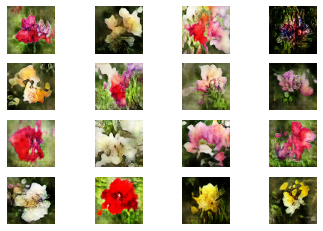

2022-09-16 08:19:36.992276: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:19:37.454683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [141/600], discriminator_loss_for_real_data = 0.004105, discriminator_loss_for_fake_data = 0.001981, generator_loss = 0.021282




2022-09-16 08:20:09.114976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [142/600], discriminator_loss_for_real_data = 0.004027, discriminator_loss_for_fake_data = 0.002057, generator_loss = 0.021252




2022-09-16 08:20:40.925769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [143/600], discriminator_loss_for_real_data = 0.004333, discriminator_loss_for_fake_data = 0.002163, generator_loss = 0.021093




2022-09-16 08:20:46.483771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [144/600], discriminator_loss_for_real_data = 0.004188, discriminator_loss_for_fake_data = 0.002006, generator_loss = 0.021214




2022-09-16 08:21:12.667799: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [145/600], discriminator_loss_for_real_data = 0.003949, discriminator_loss_for_fake_data = 0.002018, generator_loss = 0.021304


epoch -> [146/600], discriminator_loss_for_real_data = 0.003891, discriminator_loss_for_fake_data = 0.001904, generator_loss = 0.021305


epoch -> [147/600], discriminator_loss_for_real_data = 0.004109, discriminator_loss_for_fake_data = 0.001982, generator_loss = 0.021055


epoch -> [148/600], discriminator_loss_for_real_data = 0.004003, discriminator_loss_for_fake_data = 0.002075, generator_loss = 0.021071


epoch -> [149/600], discriminator_loss_for_real_data = 0.004120, discriminator_loss_for_fake_data = 0.001885, generator_loss = 0.021152




2022-09-16 08:23:19.218515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:23:19.781087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:23:26.266203: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [150/600], discriminator_loss_for_real_data = 0.004063, discriminator_loss_for_fake_data = 0.001789, generator_loss = 0.021583




2022-09-16 08:23:51.121624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:23:51.562843: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [151/600], discriminator_loss_for_real_data = 0.003705, discriminator_loss_for_fake_data = 0.001700, generator_loss = 0.021538


epoch -> [152/600], discriminator_loss_for_real_data = 0.003978, discriminator_loss_for_fake_data = 0.001931, generator_loss = 0.020971




2022-09-16 08:24:54.591349: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:24:54.965719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [153/600], discriminator_loss_for_real_data = 0.003967, discriminator_loss_for_fake_data = 0.001851, generator_loss = 0.021384


epoch -> [154/600], discriminator_loss_for_real_data = 0.004011, discriminator_loss_for_fake_data = 0.001876, generator_loss = 0.021253




2022-09-16 08:25:26.807807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [155/600], discriminator_loss_for_real_data = 0.003896, discriminator_loss_for_fake_data = 0.001809, generator_loss = 0.021358




2022-09-16 08:25:54.491688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [156/600], discriminator_loss_for_real_data = 0.004070, discriminator_loss_for_fake_data = 0.001777, generator_loss = 0.021357




2022-09-16 08:26:29.625641: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [157/600], discriminator_loss_for_real_data = 0.003991, discriminator_loss_for_fake_data = 0.001749, generator_loss = 0.021368




2022-09-16 08:26:38.485406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [158/600], discriminator_loss_for_real_data = 0.004116, discriminator_loss_for_fake_data = 0.001650, generator_loss = 0.021501




2022-09-16 08:27:01.217530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [159/600], discriminator_loss_for_real_data = 0.003894, discriminator_loss_for_fake_data = 0.001829, generator_loss = 0.020979




2022-09-16 08:27:32.638241: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [160/600], discriminator_loss_for_real_data = 0.003818, discriminator_loss_for_fake_data = 0.001714, generator_loss = 0.021382


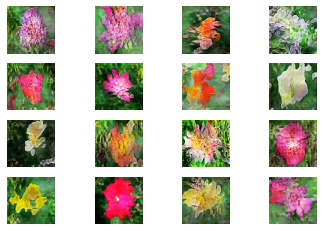



epoch -> [161/600], discriminator_loss_for_real_data = 0.003960, discriminator_loss_for_fake_data = 0.001678, generator_loss = 0.021253




2022-09-16 08:28:37.014902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [162/600], discriminator_loss_for_real_data = 0.003818, discriminator_loss_for_fake_data = 0.001709, generator_loss = 0.021551


epoch -> [163/600], discriminator_loss_for_real_data = 0.003761, discriminator_loss_for_fake_data = 0.001725, generator_loss = 0.021273




2022-09-16 08:29:08.612881: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:29:08.752999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [164/600], discriminator_loss_for_real_data = 0.003790, discriminator_loss_for_fake_data = 0.001732, generator_loss = 0.021236




2022-09-16 08:29:56.501481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [165/600], discriminator_loss_for_real_data = 0.003915, discriminator_loss_for_fake_data = 0.001503, generator_loss = 0.021325


epoch -> [166/600], discriminator_loss_for_real_data = 0.003775, discriminator_loss_for_fake_data = 0.001502, generator_loss = 0.021583


epoch -> [167/600], discriminator_loss_for_real_data = 0.003619, discriminator_loss_for_fake_data = 0.001599, generator_loss = 0.021457




2022-09-16 08:30:51.526304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [168/600], discriminator_loss_for_real_data = 0.003836, discriminator_loss_for_fake_data = 0.001619, generator_loss = 0.021396




2022-09-16 08:31:13.270566: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [169/600], discriminator_loss_for_real_data = 0.003843, discriminator_loss_for_fake_data = 0.001664, generator_loss = 0.021102


epoch -> [170/600], discriminator_loss_for_real_data = 0.003941, discriminator_loss_for_fake_data = 0.001622, generator_loss = 0.021171




2022-09-16 08:32:19.072730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [171/600], discriminator_loss_for_real_data = 0.003727, discriminator_loss_for_fake_data = 0.001696, generator_loss = 0.021245




2022-09-16 08:32:50.773873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:32:50.848930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:32:50.913867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:32:50.991790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [172/600], discriminator_loss_for_real_data = 0.003734, discriminator_loss_for_fake_data = 0.001559, generator_loss = 0.021543


epoch -> [173/600], discriminator_loss_for_real_data = 0.003618, discriminator_loss_for_fake_data = 0.001595, generator_loss = 0.021527




2022-09-16 08:33:21.812921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:33:21.882043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [174/600], discriminator_loss_for_real_data = 0.003767, discriminator_loss_for_fake_data = 0.001592, generator_loss = 0.021401




2022-09-16 08:33:54.110666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [175/600], discriminator_loss_for_real_data = 0.003893, discriminator_loss_for_fake_data = 0.001474, generator_loss = 0.021555




2022-09-16 08:34:25.574803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [176/600], discriminator_loss_for_real_data = 0.003713, discriminator_loss_for_fake_data = 0.001590, generator_loss = 0.021385


epoch -> [177/600], discriminator_loss_for_real_data = 0.003627, discriminator_loss_for_fake_data = 0.001623, generator_loss = 0.021414




2022-09-16 08:35:04.266710: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [178/600], discriminator_loss_for_real_data = 0.003633, discriminator_loss_for_fake_data = 0.001510, generator_loss = 0.021333




2022-09-16 08:35:26.233055: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:35:29.006750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:35:29.293804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [179/600], discriminator_loss_for_real_data = 0.003653, discriminator_loss_for_fake_data = 0.001501, generator_loss = 0.021512




2022-09-16 08:36:01.172745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [180/600], discriminator_loss_for_real_data = 0.003637, discriminator_loss_for_fake_data = 0.001497, generator_loss = 0.021556


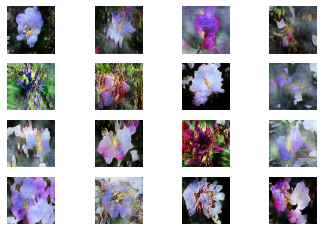

2022-09-16 08:36:32.697432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:36:32.931785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [181/600], discriminator_loss_for_real_data = 0.003625, discriminator_loss_for_fake_data = 0.001483, generator_loss = 0.021552


epoch -> [182/600], discriminator_loss_for_real_data = 0.003823, discriminator_loss_for_fake_data = 0.001527, generator_loss = 0.021428


epoch -> [183/600], discriminator_loss_for_real_data = 0.003772, discriminator_loss_for_fake_data = 0.001505, generator_loss = 0.021567




2022-09-16 08:37:35.417300: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [184/600], discriminator_loss_for_real_data = 0.003571, discriminator_loss_for_fake_data = 0.001510, generator_loss = 0.021535




2022-09-16 08:38:07.445223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [185/600], discriminator_loss_for_real_data = 0.003658, discriminator_loss_for_fake_data = 0.001396, generator_loss = 0.021525




2022-09-16 08:38:22.117882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [186/600], discriminator_loss_for_real_data = 0.003557, discriminator_loss_for_fake_data = 0.001432, generator_loss = 0.021562




2022-09-16 08:39:06.415902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [187/600], discriminator_loss_for_real_data = 0.003659, discriminator_loss_for_fake_data = 0.001403, generator_loss = 0.021592




2022-09-16 08:39:28.379028: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [188/600], discriminator_loss_for_real_data = 0.003599, discriminator_loss_for_fake_data = 0.001484, generator_loss = 0.021618




2022-09-16 08:39:42.781639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [189/600], discriminator_loss_for_real_data = 0.003556, discriminator_loss_for_fake_data = 0.001328, generator_loss = 0.021621




2022-09-16 08:40:12.110963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [190/600], discriminator_loss_for_real_data = 0.003615, discriminator_loss_for_fake_data = 0.001389, generator_loss = 0.021524


epoch -> [191/600], discriminator_loss_for_real_data = 0.003743, discriminator_loss_for_fake_data = 0.001463, generator_loss = 0.021453


epoch -> [192/600], discriminator_loss_for_real_data = 0.003583, discriminator_loss_for_fake_data = 0.001395, generator_loss = 0.021459


epoch -> [193/600], discriminator_loss_for_real_data = 0.003585, discriminator_loss_for_fake_data = 0.001436, generator_loss = 0.021467




2022-09-16 08:41:50.188904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:41:50.328831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [194/600], discriminator_loss_for_real_data = 0.003555, discriminator_loss_for_fake_data = 0.001348, generator_loss = 0.021770




2022-09-16 08:42:21.076680: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [195/600], discriminator_loss_for_real_data = 0.003452, discriminator_loss_for_fake_data = 0.001337, generator_loss = 0.021550




2022-09-16 08:42:53.316388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [196/600], discriminator_loss_for_real_data = 0.003483, discriminator_loss_for_fake_data = 0.001256, generator_loss = 0.021615




2022-09-16 08:43:08.317465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [197/600], discriminator_loss_for_real_data = 0.003593, discriminator_loss_for_fake_data = 0.001448, generator_loss = 0.021679




2022-09-16 08:43:24.636171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:43:25.480509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [198/600], discriminator_loss_for_real_data = 0.003500, discriminator_loss_for_fake_data = 0.001220, generator_loss = 0.022042


epoch -> [199/600], discriminator_loss_for_real_data = 0.003424, discriminator_loss_for_fake_data = 0.001255, generator_loss = 0.021690




2022-09-16 08:44:25.334296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [200/600], discriminator_loss_for_real_data = 0.003538, discriminator_loss_for_fake_data = 0.001337, generator_loss = 0.021549


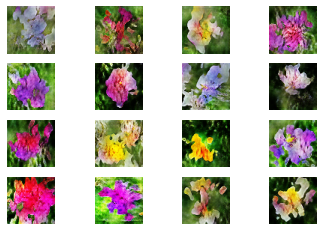

2022-09-16 08:45:00.472132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [201/600], discriminator_loss_for_real_data = 0.003384, discriminator_loss_for_fake_data = 0.001264, generator_loss = 0.021605


epoch -> [202/600], discriminator_loss_for_real_data = 0.003396, discriminator_loss_for_fake_data = 0.001259, generator_loss = 0.021989




2022-09-16 08:45:32.380080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:45:32.454861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:45:32.520955: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [203/600], discriminator_loss_for_real_data = 0.003570, discriminator_loss_for_fake_data = 0.001362, generator_loss = 0.021652




2022-09-16 08:46:03.464887: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:46:04.727976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [204/600], discriminator_loss_for_real_data = 0.003428, discriminator_loss_for_fake_data = 0.001338, generator_loss = 0.021740




2022-09-16 08:46:35.644910: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [205/600], discriminator_loss_for_real_data = 0.003322, discriminator_loss_for_fake_data = 0.001299, generator_loss = 0.021680




2022-09-16 08:47:10.653781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [206/600], discriminator_loss_for_real_data = 0.003511, discriminator_loss_for_fake_data = 0.001321, generator_loss = 0.021760


epoch -> [207/600], discriminator_loss_for_real_data = 0.003415, discriminator_loss_for_fake_data = 0.001336, generator_loss = 0.021606




2022-09-16 08:47:38.485008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [208/600], discriminator_loss_for_real_data = 0.003341, discriminator_loss_for_fake_data = 0.001324, generator_loss = 0.021798




2022-09-16 08:48:10.269549: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:48:10.869886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [209/600], discriminator_loss_for_real_data = 0.003375, discriminator_loss_for_fake_data = 0.001296, generator_loss = 0.021736




2022-09-16 08:48:42.782392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [210/600], discriminator_loss_for_real_data = 0.003534, discriminator_loss_for_fake_data = 0.001289, generator_loss = 0.021637




2022-09-16 08:49:13.861021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:49:14.551883: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [211/600], discriminator_loss_for_real_data = 0.003475, discriminator_loss_for_fake_data = 0.001323, generator_loss = 0.021598


epoch -> [212/600], discriminator_loss_for_real_data = 0.003462, discriminator_loss_for_fake_data = 0.001360, generator_loss = 0.021707


epoch -> [213/600], discriminator_loss_for_real_data = 0.003454, discriminator_loss_for_fake_data = 0.001187, generator_loss = 0.021718


epoch -> [214/600], discriminator_loss_for_real_data = 0.003307, discriminator_loss_for_fake_data = 0.001216, generator_loss = 0.021800


epoch -> [215/600], discriminator_loss_for_real_data = 0.003599, discriminator_loss_for_fake_data = 0.001315, generator_loss = 0.021718




2022-09-16 08:51:21.254152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [216/600], discriminator_loss_for_real_data = 0.003425, discriminator_loss_for_fake_data = 0.001308, generator_loss = 0.021619


epoch -> [217/600], discriminator_loss_for_real_data = 0.003664, discriminator_loss_for_fake_data = 0.001329, generator_loss = 0.021702




2022-09-16 08:51:56.240500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [218/600], discriminator_loss_for_real_data = 0.003410, discriminator_loss_for_fake_data = 0.001196, generator_loss = 0.021823




2022-09-16 08:52:29.326597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [219/600], discriminator_loss_for_real_data = 0.003336, discriminator_loss_for_fake_data = 0.001338, generator_loss = 0.021737




2022-09-16 08:52:56.357052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [220/600], discriminator_loss_for_real_data = 0.003255, discriminator_loss_for_fake_data = 0.001099, generator_loss = 0.021787


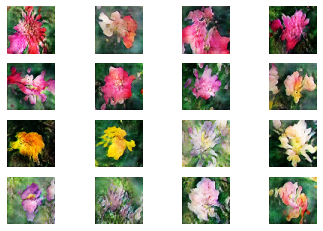

2022-09-16 08:53:27.709031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [221/600], discriminator_loss_for_real_data = 0.003382, discriminator_loss_for_fake_data = 0.001309, generator_loss = 0.021695


epoch -> [222/600], discriminator_loss_for_real_data = 0.003421, discriminator_loss_for_fake_data = 0.001284, generator_loss = 0.021934


epoch -> [223/600], discriminator_loss_for_real_data = 0.003423, discriminator_loss_for_fake_data = 0.001338, generator_loss = 0.021767




2022-09-16 08:54:32.020664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [224/600], discriminator_loss_for_real_data = 0.003438, discriminator_loss_for_fake_data = 0.001296, generator_loss = 0.021792


epoch -> [225/600], discriminator_loss_for_real_data = 0.003451, discriminator_loss_for_fake_data = 0.000998, generator_loss = 0.022385




2022-09-16 08:55:34.669999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [226/600], discriminator_loss_for_real_data = 0.003381, discriminator_loss_for_fake_data = 0.001245, generator_loss = 0.021545


epoch -> [227/600], discriminator_loss_for_real_data = 0.003195, discriminator_loss_for_fake_data = 0.001171, generator_loss = 0.021783




2022-09-16 08:56:20.270592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [228/600], discriminator_loss_for_real_data = 0.003397, discriminator_loss_for_fake_data = 0.001230, generator_loss = 0.021790


epoch -> [229/600], discriminator_loss_for_real_data = 0.003370, discriminator_loss_for_fake_data = 0.001174, generator_loss = 0.021612


epoch -> [230/600], discriminator_loss_for_real_data = 0.003405, discriminator_loss_for_fake_data = 0.001225, generator_loss = 0.021804




2022-09-16 08:57:42.154923: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:57:42.439667: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [231/600], discriminator_loss_for_real_data = 0.003207, discriminator_loss_for_fake_data = 0.001178, generator_loss = 0.021875


epoch -> [232/600], discriminator_loss_for_real_data = 0.003417, discriminator_loss_for_fake_data = 0.001204, generator_loss = 0.021784


epoch -> [233/600], discriminator_loss_for_real_data = 0.003387, discriminator_loss_for_fake_data = 0.001149, generator_loss = 0.021739


epoch -> [234/600], discriminator_loss_for_real_data = 0.003329, discriminator_loss_for_fake_data = 0.001098, generator_loss = 0.021798


epoch -> [235/600], discriminator_loss_for_real_data = 0.003347, discriminator_loss_for_fake_data = 0.001093, generator_loss = 0.021836




2022-09-16 08:59:49.461170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 08:59:49.783074: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [236/600], discriminator_loss_for_real_data = 0.003252, discriminator_loss_for_fake_data = 0.001127, generator_loss = 0.022002




2022-09-16 09:00:20.483900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [237/600], discriminator_loss_for_real_data = 0.003236, discriminator_loss_for_fake_data = 0.001111, generator_loss = 0.021867


epoch -> [238/600], discriminator_loss_for_real_data = 0.003286, discriminator_loss_for_fake_data = 0.001165, generator_loss = 0.021882




2022-09-16 09:01:06.461988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [239/600], discriminator_loss_for_real_data = 0.003383, discriminator_loss_for_fake_data = 0.001128, generator_loss = 0.021643




2022-09-16 09:01:23.739800: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [240/600], discriminator_loss_for_real_data = 0.003288, discriminator_loss_for_fake_data = 0.001114, generator_loss = 0.021946


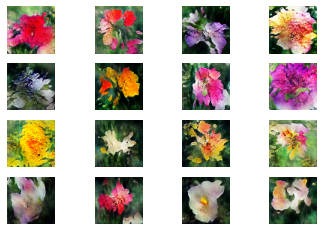



epoch -> [241/600], discriminator_loss_for_real_data = 0.003181, discriminator_loss_for_fake_data = 0.001084, generator_loss = 0.022082


epoch -> [242/600], discriminator_loss_for_real_data = 0.003444, discriminator_loss_for_fake_data = 0.001122, generator_loss = 0.021905


epoch -> [243/600], discriminator_loss_for_real_data = 0.003317, discriminator_loss_for_fake_data = 0.001095, generator_loss = 0.021718


epoch -> [244/600], discriminator_loss_for_real_data = 0.003174, discriminator_loss_for_fake_data = 0.001028, generator_loss = 0.021851




2022-09-16 09:03:31.170726: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [245/600], discriminator_loss_for_real_data = 0.003161, discriminator_loss_for_fake_data = 0.001147, generator_loss = 0.021922




2022-09-16 09:03:51.415941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [246/600], discriminator_loss_for_real_data = 0.003188, discriminator_loss_for_fake_data = 0.001055, generator_loss = 0.022108


epoch -> [247/600], discriminator_loss_for_real_data = 0.003253, discriminator_loss_for_fake_data = 0.001051, generator_loss = 0.022019


epoch -> [248/600], discriminator_loss_for_real_data = 0.003168, discriminator_loss_for_fake_data = 0.001134, generator_loss = 0.021799


epoch -> [249/600], discriminator_loss_for_real_data = 0.003311, discriminator_loss_for_fake_data = 0.001067, generator_loss = 0.022157


epoch -> [250/600], discriminator_loss_for_real_data = 0.003331, discriminator_loss_for_fake_data = 0.001085, generator_loss = 0.021837




2022-09-16 09:06:10.139043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:06:10.349818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [251/600], discriminator_loss_for_real_data = 0.003271, discriminator_loss_for_fake_data = 0.001178, generator_loss = 0.021833




2022-09-16 09:06:42.066468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [252/600], discriminator_loss_for_real_data = 0.003186, discriminator_loss_for_fake_data = 0.001027, generator_loss = 0.021959


epoch -> [253/600], discriminator_loss_for_real_data = 0.003255, discriminator_loss_for_fake_data = 0.001076, generator_loss = 0.022028




2022-09-16 09:07:13.529844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:07:20.529606: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [254/600], discriminator_loss_for_real_data = 0.003108, discriminator_loss_for_fake_data = 0.001067, generator_loss = 0.022135


epoch -> [255/600], discriminator_loss_for_real_data = 0.003124, discriminator_loss_for_fake_data = 0.000960, generator_loss = 0.022044




2022-09-16 09:08:16.357952: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [256/600], discriminator_loss_for_real_data = 0.003154, discriminator_loss_for_fake_data = 0.001008, generator_loss = 0.021977




2022-09-16 09:08:48.452518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:08:48.610776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:08:48.696671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:08:48.937992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [257/600], discriminator_loss_for_real_data = 0.003113, discriminator_loss_for_fake_data = 0.000998, generator_loss = 0.021904


epoch -> [258/600], discriminator_loss_for_real_data = 0.003095, discriminator_loss_for_fake_data = 0.001072, generator_loss = 0.021966


epoch -> [259/600], discriminator_loss_for_real_data = 0.003253, discriminator_loss_for_fake_data = 0.000951, generator_loss = 0.022184




2022-09-16 09:09:51.907694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:09:52.047655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:09:52.421666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [260/600], discriminator_loss_for_real_data = 0.003184, discriminator_loss_for_fake_data = 0.001068, generator_loss = 0.021929


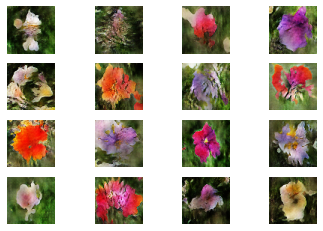



epoch -> [261/600], discriminator_loss_for_real_data = 0.003113, discriminator_loss_for_fake_data = 0.001047, generator_loss = 0.022004




2022-09-16 09:10:55.573964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:10:55.725884: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:10:55.867412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [262/600], discriminator_loss_for_real_data = 0.003143, discriminator_loss_for_fake_data = 0.001004, generator_loss = 0.021733




2022-09-16 09:11:00.517883: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:11:11.564391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [263/600], discriminator_loss_for_real_data = 0.003149, discriminator_loss_for_fake_data = 0.000992, generator_loss = 0.021947




2022-09-16 09:11:27.242943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:11:27.591798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:11:33.582037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [264/600], discriminator_loss_for_real_data = 0.002928, discriminator_loss_for_fake_data = 0.000944, generator_loss = 0.022099




2022-09-16 09:11:59.100783: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [265/600], discriminator_loss_for_real_data = 0.003102, discriminator_loss_for_fake_data = 0.000982, generator_loss = 0.022197


epoch -> [266/600], discriminator_loss_for_real_data = 0.003165, discriminator_loss_for_fake_data = 0.001009, generator_loss = 0.022021




2022-09-16 09:13:01.660317: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:13:02.222128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [267/600], discriminator_loss_for_real_data = 0.003029, discriminator_loss_for_fake_data = 0.000968, generator_loss = 0.022201


epoch -> [268/600], discriminator_loss_for_real_data = 0.003087, discriminator_loss_for_fake_data = 0.000860, generator_loss = 0.022259


epoch -> [269/600], discriminator_loss_for_real_data = 0.003137, discriminator_loss_for_fake_data = 0.000972, generator_loss = 0.022155




2022-09-16 09:14:05.858022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [270/600], discriminator_loss_for_real_data = 0.003170, discriminator_loss_for_fake_data = 0.000995, generator_loss = 0.021977


epoch -> [271/600], discriminator_loss_for_real_data = 0.003113, discriminator_loss_for_fake_data = 0.000958, generator_loss = 0.022084




2022-09-16 09:15:09.330722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [272/600], discriminator_loss_for_real_data = 0.003080, discriminator_loss_for_fake_data = 0.000975, generator_loss = 0.021897




2022-09-16 09:15:24.143400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [273/600], discriminator_loss_for_real_data = 0.003087, discriminator_loss_for_fake_data = 0.000941, generator_loss = 0.022283




2022-09-16 09:15:41.368596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:15:41.442181: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:15:57.645010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [274/600], discriminator_loss_for_real_data = 0.003103, discriminator_loss_for_fake_data = 0.001016, generator_loss = 0.021936


epoch -> [275/600], discriminator_loss_for_real_data = 0.003117, discriminator_loss_for_fake_data = 0.001053, generator_loss = 0.021967




2022-09-16 09:16:43.861064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [276/600], discriminator_loss_for_real_data = 0.003050, discriminator_loss_for_fake_data = 0.000949, generator_loss = 0.022239




2022-09-16 09:17:15.752178: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:17:16.548647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [277/600], discriminator_loss_for_real_data = 0.003058, discriminator_loss_for_fake_data = 0.000907, generator_loss = 0.022064


epoch -> [278/600], discriminator_loss_for_real_data = 0.002904, discriminator_loss_for_fake_data = 0.000906, generator_loss = 0.022284




2022-09-16 09:17:53.310794: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [279/600], discriminator_loss_for_real_data = 0.003089, discriminator_loss_for_fake_data = 0.000901, generator_loss = 0.022421




2022-09-16 09:18:19.515335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [280/600], discriminator_loss_for_real_data = 0.003204, discriminator_loss_for_fake_data = 0.000939, generator_loss = 0.021956


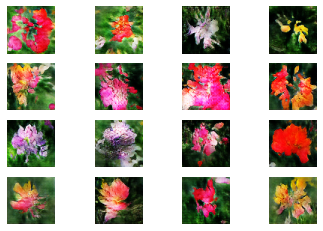

2022-09-16 09:18:51.602775: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:18:53.231789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [281/600], discriminator_loss_for_real_data = 0.003057, discriminator_loss_for_fake_data = 0.000965, generator_loss = 0.022117




2022-09-16 09:19:26.276777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [282/600], discriminator_loss_for_real_data = 0.003029, discriminator_loss_for_fake_data = 0.000856, generator_loss = 0.022162




2022-09-16 09:19:37.633870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [283/600], discriminator_loss_for_real_data = 0.002989, discriminator_loss_for_fake_data = 0.000939, generator_loss = 0.022079




2022-09-16 09:19:55.437789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [284/600], discriminator_loss_for_real_data = 0.002957, discriminator_loss_for_fake_data = 0.000902, generator_loss = 0.022064




2022-09-16 09:20:27.107750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [285/600], discriminator_loss_for_real_data = 0.003019, discriminator_loss_for_fake_data = 0.000909, generator_loss = 0.022226




2022-09-16 09:20:58.660086: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [286/600], discriminator_loss_for_real_data = 0.002902, discriminator_loss_for_fake_data = 0.000935, generator_loss = 0.022163


epoch -> [287/600], discriminator_loss_for_real_data = 0.003055, discriminator_loss_for_fake_data = 0.000853, generator_loss = 0.022308


epoch -> [288/600], discriminator_loss_for_real_data = 0.002878, discriminator_loss_for_fake_data = 0.000845, generator_loss = 0.022269




2022-09-16 09:22:01.512206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [289/600], discriminator_loss_for_real_data = 0.003015, discriminator_loss_for_fake_data = 0.000929, generator_loss = 0.021991


epoch -> [290/600], discriminator_loss_for_real_data = 0.002926, discriminator_loss_for_fake_data = 0.000889, generator_loss = 0.022332




2022-09-16 09:23:04.981465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [291/600], discriminator_loss_for_real_data = 0.002976, discriminator_loss_for_fake_data = 0.000852, generator_loss = 0.022357




2022-09-16 09:23:37.185714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [292/600], discriminator_loss_for_real_data = 0.002919, discriminator_loss_for_fake_data = 0.000851, generator_loss = 0.022251


epoch -> [293/600], discriminator_loss_for_real_data = 0.003018, discriminator_loss_for_fake_data = 0.000864, generator_loss = 0.022178


epoch -> [294/600], discriminator_loss_for_real_data = 0.003008, discriminator_loss_for_fake_data = 0.000852, generator_loss = 0.022303




2022-09-16 09:24:40.368818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:24:40.433685: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:24:40.728079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:24:40.802787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [295/600], discriminator_loss_for_real_data = 0.002919, discriminator_loss_for_fake_data = 0.000821, generator_loss = 0.022460


epoch -> [296/600], discriminator_loss_for_real_data = 0.002907, discriminator_loss_for_fake_data = 0.000934, generator_loss = 0.021928




2022-09-16 09:25:43.887965: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [297/600], discriminator_loss_for_real_data = 0.003026, discriminator_loss_for_fake_data = 0.000857, generator_loss = 0.022236




2022-09-16 09:26:02.329017: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [298/600], discriminator_loss_for_real_data = 0.003002, discriminator_loss_for_fake_data = 0.000903, generator_loss = 0.022194


epoch -> [299/600], discriminator_loss_for_real_data = 0.002948, discriminator_loss_for_fake_data = 0.000838, generator_loss = 0.022229


epoch -> [300/600], discriminator_loss_for_real_data = 0.002891, discriminator_loss_for_fake_data = 0.000831, generator_loss = 0.022409


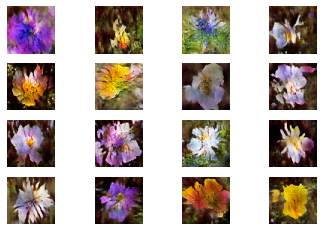



epoch -> [301/600], discriminator_loss_for_real_data = 0.002871, discriminator_loss_for_fake_data = 0.000848, generator_loss = 0.022250




2022-09-16 09:27:52.240135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [302/600], discriminator_loss_for_real_data = 0.002874, discriminator_loss_for_fake_data = 0.000845, generator_loss = 0.022328


epoch -> [303/600], discriminator_loss_for_real_data = 0.002825, discriminator_loss_for_fake_data = 0.000872, generator_loss = 0.022327


epoch -> [304/600], discriminator_loss_for_real_data = 0.002900, discriminator_loss_for_fake_data = 0.000798, generator_loss = 0.022258


epoch -> [305/600], discriminator_loss_for_real_data = 0.002907, discriminator_loss_for_fake_data = 0.000860, generator_loss = 0.022417


epoch -> [306/600], discriminator_loss_for_real_data = 0.002964, discriminator_loss_for_fake_data = 0.000819, generator_loss = 0.022334


epoch -> [307/600], discriminator_loss_for_real_data = 0.002949, discriminator_loss_for_fake_data = 0.000816, generator_loss = 0.022338




2022-09-16 09:30:26.252819: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [308/600], discriminator_loss_for_real_data = 0.003026, discriminator_loss_for_fake_data = 0.000796, generator_loss = 0.022184




2022-09-16 09:30:29.750644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [309/600], discriminator_loss_for_real_data = 0.002648, discriminator_loss_for_fake_data = 0.000806, generator_loss = 0.022403


epoch -> [310/600], discriminator_loss_for_real_data = 0.002861, discriminator_loss_for_fake_data = 0.000788, generator_loss = 0.022382




2022-09-16 09:31:43.484870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [311/600], discriminator_loss_for_real_data = 0.002871, discriminator_loss_for_fake_data = 0.000801, generator_loss = 0.022301




2022-09-16 09:32:04.208931: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [312/600], discriminator_loss_for_real_data = 0.002865, discriminator_loss_for_fake_data = 0.000721, generator_loss = 0.022361


epoch -> [313/600], discriminator_loss_for_real_data = 0.002817, discriminator_loss_for_fake_data = 0.000846, generator_loss = 0.022315


epoch -> [314/600], discriminator_loss_for_real_data = 0.002782, discriminator_loss_for_fake_data = 0.000798, generator_loss = 0.022262




2022-09-16 09:33:07.607388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [315/600], discriminator_loss_for_real_data = 0.002812, discriminator_loss_for_fake_data = 0.000771, generator_loss = 0.022185




2022-09-16 09:33:39.580418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:33:39.962096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:33:40.028722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [316/600], discriminator_loss_for_real_data = 0.002799, discriminator_loss_for_fake_data = 0.000765, generator_loss = 0.022272




2022-09-16 09:34:11.822791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:34:17.537676: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [317/600], discriminator_loss_for_real_data = 0.002974, discriminator_loss_for_fake_data = 0.000799, generator_loss = 0.022197




2022-09-16 09:34:43.567919: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [318/600], discriminator_loss_for_real_data = 0.002773, discriminator_loss_for_fake_data = 0.000796, generator_loss = 0.022473


epoch -> [319/600], discriminator_loss_for_real_data = 0.002831, discriminator_loss_for_fake_data = 0.000756, generator_loss = 0.022391




2022-09-16 09:35:23.429982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:35:23.690341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [320/600], discriminator_loss_for_real_data = 0.002852, discriminator_loss_for_fake_data = 0.000748, generator_loss = 0.022404


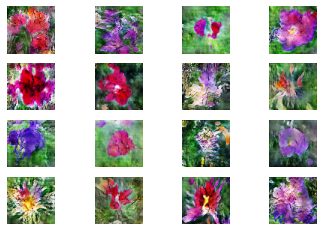



epoch -> [321/600], discriminator_loss_for_real_data = 0.002894, discriminator_loss_for_fake_data = 0.000818, generator_loss = 0.022359




2022-09-16 09:36:18.552552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:36:19.268445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [322/600], discriminator_loss_for_real_data = 0.002925, discriminator_loss_for_fake_data = 0.000779, generator_loss = 0.022284


epoch -> [323/600], discriminator_loss_for_real_data = 0.002757, discriminator_loss_for_fake_data = 0.000739, generator_loss = 0.022507


epoch -> [324/600], discriminator_loss_for_real_data = 0.002791, discriminator_loss_for_fake_data = 0.000792, generator_loss = 0.022282


epoch -> [325/600], discriminator_loss_for_real_data = 0.002717, discriminator_loss_for_fake_data = 0.000788, generator_loss = 0.022505




2022-09-16 09:37:53.310942: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [326/600], discriminator_loss_for_real_data = 0.002702, discriminator_loss_for_fake_data = 0.000686, generator_loss = 0.022362


epoch -> [327/600], discriminator_loss_for_real_data = 0.002825, discriminator_loss_for_fake_data = 0.000747, generator_loss = 0.022253




2022-09-16 09:38:41.451771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:38:57.540766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [328/600], discriminator_loss_for_real_data = 0.002839, discriminator_loss_for_fake_data = 0.000815, generator_loss = 0.022257


epoch -> [329/600], discriminator_loss_for_real_data = 0.002733, discriminator_loss_for_fake_data = 0.000784, generator_loss = 0.022538




2022-09-16 09:39:29.047504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:39:29.113723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:39:36.633183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [330/600], discriminator_loss_for_real_data = 0.002812, discriminator_loss_for_fake_data = 0.000757, generator_loss = 0.022263




2022-09-16 09:40:00.446131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [331/600], discriminator_loss_for_real_data = 0.002916, discriminator_loss_for_fake_data = 0.000774, generator_loss = 0.022439




2022-09-16 09:40:32.953635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [332/600], discriminator_loss_for_real_data = 0.002785, discriminator_loss_for_fake_data = 0.000758, generator_loss = 0.022548




2022-09-16 09:41:04.495596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:41:04.653720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [333/600], discriminator_loss_for_real_data = 0.002778, discriminator_loss_for_fake_data = 0.000732, generator_loss = 0.022458




2022-09-16 09:41:26.508765: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [334/600], discriminator_loss_for_real_data = 0.002883, discriminator_loss_for_fake_data = 0.000794, generator_loss = 0.022320




2022-09-16 09:41:37.662100: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [335/600], discriminator_loss_for_real_data = 0.002802, discriminator_loss_for_fake_data = 0.000740, generator_loss = 0.022518




2022-09-16 09:42:07.833559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [336/600], discriminator_loss_for_real_data = 0.002654, discriminator_loss_for_fake_data = 0.000739, generator_loss = 0.022289


epoch -> [337/600], discriminator_loss_for_real_data = 0.002692, discriminator_loss_for_fake_data = 0.000719, generator_loss = 0.022420




2022-09-16 09:43:10.883180: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [338/600], discriminator_loss_for_real_data = 0.002726, discriminator_loss_for_fake_data = 0.000757, generator_loss = 0.022494




2022-09-16 09:43:38.436237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:43:38.525082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [339/600], discriminator_loss_for_real_data = 0.002720, discriminator_loss_for_fake_data = 0.000668, generator_loss = 0.022374


epoch -> [340/600], discriminator_loss_for_real_data = 0.002747, discriminator_loss_for_fake_data = 0.000795, generator_loss = 0.022472


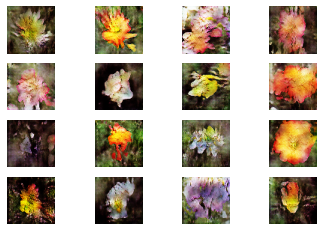

2022-09-16 09:44:11.115302: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [341/600], discriminator_loss_for_real_data = 0.002712, discriminator_loss_for_fake_data = 0.000702, generator_loss = 0.022302


epoch -> [342/600], discriminator_loss_for_real_data = 0.002651, discriminator_loss_for_fake_data = 0.000721, generator_loss = 0.022349


epoch -> [343/600], discriminator_loss_for_real_data = 0.002787, discriminator_loss_for_fake_data = 0.000693, generator_loss = 0.022363


epoch -> [344/600], discriminator_loss_for_real_data = 0.002657, discriminator_loss_for_fake_data = 0.000707, generator_loss = 0.022695


epoch -> [345/600], discriminator_loss_for_real_data = 0.002794, discriminator_loss_for_fake_data = 0.000685, generator_loss = 0.022416


epoch -> [346/600], discriminator_loss_for_real_data = 0.002638, discriminator_loss_for_fake_data = 0.000798, generator_loss = 0.022577




2022-09-16 09:46:53.482714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [347/600], discriminator_loss_for_real_data = 0.002658, discriminator_loss_for_fake_data = 0.000748, generator_loss = 0.022563


epoch -> [348/600], discriminator_loss_for_real_data = 0.002739, discriminator_loss_for_fake_data = 0.000778, generator_loss = 0.022440




2022-09-16 09:47:40.222256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:47:57.250754: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [349/600], discriminator_loss_for_real_data = 0.002728, discriminator_loss_for_fake_data = 0.000699, generator_loss = 0.022712


epoch -> [350/600], discriminator_loss_for_real_data = 0.002670, discriminator_loss_for_fake_data = 0.000703, generator_loss = 0.022426




2022-09-16 09:48:28.297025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [351/600], discriminator_loss_for_real_data = 0.002703, discriminator_loss_for_fake_data = 0.000715, generator_loss = 0.022577




2022-09-16 09:49:00.708607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [352/600], discriminator_loss_for_real_data = 0.002709, discriminator_loss_for_fake_data = 0.000754, generator_loss = 0.022411




2022-09-16 09:49:31.598043: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:49:31.747082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [353/600], discriminator_loss_for_real_data = 0.002524, discriminator_loss_for_fake_data = 0.000711, generator_loss = 0.022631


epoch -> [354/600], discriminator_loss_for_real_data = 0.002566, discriminator_loss_for_fake_data = 0.000639, generator_loss = 0.022591




2022-09-16 09:50:25.215702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [355/600], discriminator_loss_for_real_data = 0.002672, discriminator_loss_for_fake_data = 0.000651, generator_loss = 0.022595


epoch -> [356/600], discriminator_loss_for_real_data = 0.002636, discriminator_loss_for_fake_data = 0.000674, generator_loss = 0.022552




2022-09-16 09:51:06.926290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:51:09.557119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [357/600], discriminator_loss_for_real_data = 0.002742, discriminator_loss_for_fake_data = 0.000662, generator_loss = 0.022497


epoch -> [358/600], discriminator_loss_for_real_data = 0.002623, discriminator_loss_for_fake_data = 0.000686, generator_loss = 0.022569


epoch -> [359/600], discriminator_loss_for_real_data = 0.002648, discriminator_loss_for_fake_data = 0.000686, generator_loss = 0.022519


epoch -> [360/600], discriminator_loss_for_real_data = 0.002699, discriminator_loss_for_fake_data = 0.000682, generator_loss = 0.022468


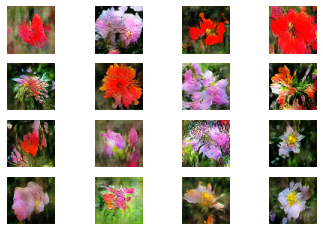



epoch -> [361/600], discriminator_loss_for_real_data = 0.002638, discriminator_loss_for_fake_data = 0.000673, generator_loss = 0.022710




2022-09-16 09:53:10.260442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [362/600], discriminator_loss_for_real_data = 0.002642, discriminator_loss_for_fake_data = 0.000702, generator_loss = 0.022644


epoch -> [363/600], discriminator_loss_for_real_data = 0.002612, discriminator_loss_for_fake_data = 0.000663, generator_loss = 0.022580


epoch -> [364/600], discriminator_loss_for_real_data = 0.002515, discriminator_loss_for_fake_data = 0.000686, generator_loss = 0.022535


epoch -> [365/600], discriminator_loss_for_real_data = 0.002543, discriminator_loss_for_fake_data = 0.000665, generator_loss = 0.022530




2022-09-16 09:54:49.646415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:54:49.727225: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 09:54:49.875492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [366/600], discriminator_loss_for_real_data = 0.002572, discriminator_loss_for_fake_data = 0.000669, generator_loss = 0.022515


epoch -> [367/600], discriminator_loss_for_real_data = 0.002570, discriminator_loss_for_fake_data = 0.000646, generator_loss = 0.022649




2022-09-16 09:55:52.954774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [368/600], discriminator_loss_for_real_data = 0.002540, discriminator_loss_for_fake_data = 0.000651, generator_loss = 0.022617


epoch -> [369/600], discriminator_loss_for_real_data = 0.002605, discriminator_loss_for_fake_data = 0.000614, generator_loss = 0.022605


epoch -> [370/600], discriminator_loss_for_real_data = 0.002731, discriminator_loss_for_fake_data = 0.000618, generator_loss = 0.022695


epoch -> [371/600], discriminator_loss_for_real_data = 0.002676, discriminator_loss_for_fake_data = 0.000701, generator_loss = 0.022579


epoch -> [372/600], discriminator_loss_for_real_data = 0.002569, discriminator_loss_for_fake_data = 0.000658, generator_loss = 0.022538




2022-09-16 09:58:02.707052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [373/600], discriminator_loss_for_real_data = 0.002568, discriminator_loss_for_fake_data = 0.000650, generator_loss = 0.022527


epoch -> [374/600], discriminator_loss_for_real_data = 0.002669, discriminator_loss_for_fake_data = 0.000666, generator_loss = 0.022599


epoch -> [375/600], discriminator_loss_for_real_data = 0.002603, discriminator_loss_for_fake_data = 0.000632, generator_loss = 0.022698


epoch -> [376/600], discriminator_loss_for_real_data = 0.002647, discriminator_loss_for_fake_data = 0.000642, generator_loss = 0.022654


epoch -> [377/600], discriminator_loss_for_real_data = 0.002567, discriminator_loss_for_fake_data = 0.000644, generator_loss = 0.022612




2022-09-16 10:00:19.339544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [378/600], discriminator_loss_for_real_data = 0.002477, discriminator_loss_for_fake_data = 0.000632, generator_loss = 0.022669




2022-09-16 10:00:41.673042: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:00:41.753999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:00:41.904966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [379/600], discriminator_loss_for_real_data = 0.002483, discriminator_loss_for_fake_data = 0.000623, generator_loss = 0.022738


epoch -> [380/600], discriminator_loss_for_real_data = 0.002533, discriminator_loss_for_fake_data = 0.000636, generator_loss = 0.022670


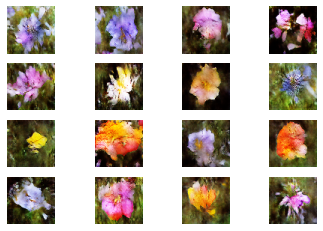



epoch -> [381/600], discriminator_loss_for_real_data = 0.002611, discriminator_loss_for_fake_data = 0.000643, generator_loss = 0.022520




2022-09-16 10:01:45.286547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [382/600], discriminator_loss_for_real_data = 0.002471, discriminator_loss_for_fake_data = 0.000633, generator_loss = 0.022722


epoch -> [383/600], discriminator_loss_for_real_data = 0.002612, discriminator_loss_for_fake_data = 0.000650, generator_loss = 0.022636


epoch -> [384/600], discriminator_loss_for_real_data = 0.002570, discriminator_loss_for_fake_data = 0.000604, generator_loss = 0.022665




2022-09-16 10:03:20.388544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [385/600], discriminator_loss_for_real_data = 0.002580, discriminator_loss_for_fake_data = 0.000634, generator_loss = 0.022606


epoch -> [386/600], discriminator_loss_for_real_data = 0.002617, discriminator_loss_for_fake_data = 0.000670, generator_loss = 0.022633




2022-09-16 10:03:51.982827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [387/600], discriminator_loss_for_real_data = 0.002548, discriminator_loss_for_fake_data = 0.000621, generator_loss = 0.022642


epoch -> [388/600], discriminator_loss_for_real_data = 0.002586, discriminator_loss_for_fake_data = 0.000579, generator_loss = 0.022701




2022-09-16 10:04:55.662092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:04:55.727764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [389/600], discriminator_loss_for_real_data = 0.002470, discriminator_loss_for_fake_data = 0.000634, generator_loss = 0.022615




2022-09-16 10:05:27.487025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [390/600], discriminator_loss_for_real_data = 0.002467, discriminator_loss_for_fake_data = 0.000593, generator_loss = 0.022629


epoch -> [391/600], discriminator_loss_for_real_data = 0.002564, discriminator_loss_for_fake_data = 0.000637, generator_loss = 0.022630


epoch -> [392/600], discriminator_loss_for_real_data = 0.002620, discriminator_loss_for_fake_data = 0.000610, generator_loss = 0.022687


epoch -> [393/600], discriminator_loss_for_real_data = 0.002401, discriminator_loss_for_fake_data = 0.000703, generator_loss = 0.022786




2022-09-16 10:07:01.962218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [394/600], discriminator_loss_for_real_data = 0.002610, discriminator_loss_for_fake_data = 0.000635, generator_loss = 0.022640




2022-09-16 10:07:34.290827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [395/600], discriminator_loss_for_real_data = 0.002386, discriminator_loss_for_fake_data = 0.000583, generator_loss = 0.022520


epoch -> [396/600], discriminator_loss_for_real_data = 0.002483, discriminator_loss_for_fake_data = 0.000612, generator_loss = 0.022749


epoch -> [397/600], discriminator_loss_for_real_data = 0.002511, discriminator_loss_for_fake_data = 0.000603, generator_loss = 0.022845


epoch -> [398/600], discriminator_loss_for_real_data = 0.002450, discriminator_loss_for_fake_data = 0.000625, generator_loss = 0.022613


epoch -> [399/600], discriminator_loss_for_real_data = 0.002527, discriminator_loss_for_fake_data = 0.000577, generator_loss = 0.022780




2022-09-16 10:09:41.154183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [400/600], discriminator_loss_for_real_data = 0.002496, discriminator_loss_for_fake_data = 0.000624, generator_loss = 0.022637


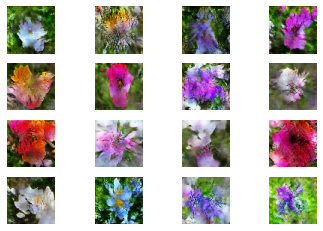

2022-09-16 10:10:11.981993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [401/600], discriminator_loss_for_real_data = 0.002532, discriminator_loss_for_fake_data = 0.000632, generator_loss = 0.022669


epoch -> [402/600], discriminator_loss_for_real_data = 0.002528, discriminator_loss_for_fake_data = 0.000583, generator_loss = 0.022814


epoch -> [403/600], discriminator_loss_for_real_data = 0.002459, discriminator_loss_for_fake_data = 0.000594, generator_loss = 0.022777




2022-09-16 10:11:16.328811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [404/600], discriminator_loss_for_real_data = 0.002551, discriminator_loss_for_fake_data = 0.000515, generator_loss = 0.022771


epoch -> [405/600], discriminator_loss_for_real_data = 0.002524, discriminator_loss_for_fake_data = 0.000633, generator_loss = 0.022613




2022-09-16 10:12:03.348546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [406/600], discriminator_loss_for_real_data = 0.002397, discriminator_loss_for_fake_data = 0.000584, generator_loss = 0.022630




2022-09-16 10:12:25.324836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:12:36.396722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:12:36.488279: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [407/600], discriminator_loss_for_real_data = 0.002429, discriminator_loss_for_fake_data = 0.000594, generator_loss = 0.022685


epoch -> [408/600], discriminator_loss_for_real_data = 0.002620, discriminator_loss_for_fake_data = 0.000586, generator_loss = 0.022622




2022-09-16 10:13:20.447979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [409/600], discriminator_loss_for_real_data = 0.002450, discriminator_loss_for_fake_data = 0.000584, generator_loss = 0.022815


epoch -> [410/600], discriminator_loss_for_real_data = 0.002584, discriminator_loss_for_fake_data = 0.000540, generator_loss = 0.022853




2022-09-16 10:14:26.632295: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:14:26.776217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [411/600], discriminator_loss_for_real_data = 0.002520, discriminator_loss_for_fake_data = 0.000594, generator_loss = 0.022578


epoch -> [412/600], discriminator_loss_for_real_data = 0.002360, discriminator_loss_for_fake_data = 0.000564, generator_loss = 0.022796




2022-09-16 10:14:57.605860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:14:59.386788: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:15:10.417546: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [413/600], discriminator_loss_for_real_data = 0.002398, discriminator_loss_for_fake_data = 0.000586, generator_loss = 0.022788




2022-09-16 10:15:29.263117: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [414/600], discriminator_loss_for_real_data = 0.002480, discriminator_loss_for_fake_data = 0.000608, generator_loss = 0.022714




2022-09-16 10:16:01.770639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [415/600], discriminator_loss_for_real_data = 0.002440, discriminator_loss_for_fake_data = 0.000619, generator_loss = 0.022619




2022-09-16 10:16:33.549764: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [416/600], discriminator_loss_for_real_data = 0.002381, discriminator_loss_for_fake_data = 0.000612, generator_loss = 0.022733


epoch -> [417/600], discriminator_loss_for_real_data = 0.002541, discriminator_loss_for_fake_data = 0.000589, generator_loss = 0.022738


epoch -> [418/600], discriminator_loss_for_real_data = 0.002372, discriminator_loss_for_fake_data = 0.000577, generator_loss = 0.022777




2022-09-16 10:17:36.041183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [419/600], discriminator_loss_for_real_data = 0.002312, discriminator_loss_for_fake_data = 0.000531, generator_loss = 0.022758


epoch -> [420/600], discriminator_loss_for_real_data = 0.002406, discriminator_loss_for_fake_data = 0.000466, generator_loss = 0.023057


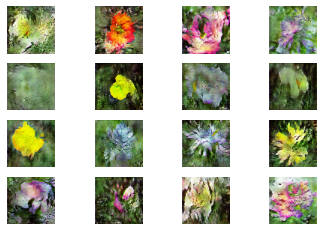



epoch -> [421/600], discriminator_loss_for_real_data = 0.002496, discriminator_loss_for_fake_data = 0.000614, generator_loss = 0.022585




2022-09-16 10:19:11.362470: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [422/600], discriminator_loss_for_real_data = 0.002495, discriminator_loss_for_fake_data = 0.000555, generator_loss = 0.022763




2022-09-16 10:19:34.333359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [423/600], discriminator_loss_for_real_data = 0.002383, discriminator_loss_for_fake_data = 0.000578, generator_loss = 0.022637




2022-09-16 10:19:43.452909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:19:44.070730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [424/600], discriminator_loss_for_real_data = 0.002465, discriminator_loss_for_fake_data = 0.000523, generator_loss = 0.022752


epoch -> [425/600], discriminator_loss_for_real_data = 0.002411, discriminator_loss_for_fake_data = 0.000575, generator_loss = 0.022716




2022-09-16 10:20:29.545354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [426/600], discriminator_loss_for_real_data = 0.002424, discriminator_loss_for_fake_data = 0.000561, generator_loss = 0.022721




2022-09-16 10:21:18.276867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:21:18.851797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [427/600], discriminator_loss_for_real_data = 0.002436, discriminator_loss_for_fake_data = 0.000531, generator_loss = 0.022785


epoch -> [428/600], discriminator_loss_for_real_data = 0.002445, discriminator_loss_for_fake_data = 0.000612, generator_loss = 0.022803




2022-09-16 10:21:50.535137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:21:50.886773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [429/600], discriminator_loss_for_real_data = 0.002478, discriminator_loss_for_fake_data = 0.000592, generator_loss = 0.022736


epoch -> [430/600], discriminator_loss_for_real_data = 0.002402, discriminator_loss_for_fake_data = 0.000570, generator_loss = 0.022741




2022-09-16 10:22:52.167282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [431/600], discriminator_loss_for_real_data = 0.002283, discriminator_loss_for_fake_data = 0.000522, generator_loss = 0.022798


epoch -> [432/600], discriminator_loss_for_real_data = 0.002387, discriminator_loss_for_fake_data = 0.000536, generator_loss = 0.022883




2022-09-16 10:23:36.349456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [433/600], discriminator_loss_for_real_data = 0.002375, discriminator_loss_for_fake_data = 0.000539, generator_loss = 0.022687




2022-09-16 10:23:57.640873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [434/600], discriminator_loss_for_real_data = 0.002389, discriminator_loss_for_fake_data = 0.000522, generator_loss = 0.022831


epoch -> [435/600], discriminator_loss_for_real_data = 0.002389, discriminator_loss_for_fake_data = 0.000509, generator_loss = 0.022883


epoch -> [436/600], discriminator_loss_for_real_data = 0.002436, discriminator_loss_for_fake_data = 0.000614, generator_loss = 0.022630


epoch -> [437/600], discriminator_loss_for_real_data = 0.002328, discriminator_loss_for_fake_data = 0.000518, generator_loss = 0.022902


epoch -> [438/600], discriminator_loss_for_real_data = 0.002332, discriminator_loss_for_fake_data = 0.000444, generator_loss = 0.023062


epoch -> [439/600], discriminator_loss_for_real_data = 0.002351, discriminator_loss_for_fake_data = 0.000551, generator_loss = 0.022694




2022-09-16 10:26:35.717000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:26:35.784950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:26:43.532606: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [440/600], discriminator_loss_for_real_data = 0.002415, discriminator_loss_for_fake_data = 0.000539, generator_loss = 0.022868


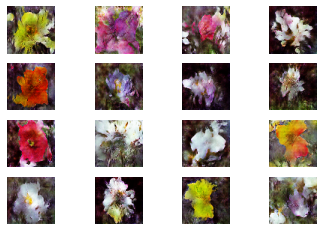

2022-09-16 10:27:08.404171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:27:16.562107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [441/600], discriminator_loss_for_real_data = 0.002360, discriminator_loss_for_fake_data = 0.000555, generator_loss = 0.022787




2022-09-16 10:27:39.170966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [442/600], discriminator_loss_for_real_data = 0.002453, discriminator_loss_for_fake_data = 0.000566, generator_loss = 0.022628




2022-09-16 10:28:10.911010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:28:11.013045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [443/600], discriminator_loss_for_real_data = 0.002310, discriminator_loss_for_fake_data = 0.000565, generator_loss = 0.023032


epoch -> [444/600], discriminator_loss_for_real_data = 0.002311, discriminator_loss_for_fake_data = 0.000527, generator_loss = 0.022884




2022-09-16 10:28:43.196856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [445/600], discriminator_loss_for_real_data = 0.002397, discriminator_loss_for_fake_data = 0.000541, generator_loss = 0.022749




2022-09-16 10:29:14.914687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [446/600], discriminator_loss_for_real_data = 0.002316, discriminator_loss_for_fake_data = 0.000517, generator_loss = 0.022767




2022-09-16 10:29:45.870613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [447/600], discriminator_loss_for_real_data = 0.002384, discriminator_loss_for_fake_data = 0.000517, generator_loss = 0.022875


epoch -> [448/600], discriminator_loss_for_real_data = 0.002378, discriminator_loss_for_fake_data = 0.000559, generator_loss = 0.022812


epoch -> [449/600], discriminator_loss_for_real_data = 0.002424, discriminator_loss_for_fake_data = 0.000474, generator_loss = 0.022911




2022-09-16 10:30:49.527128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [450/600], discriminator_loss_for_real_data = 0.002377, discriminator_loss_for_fake_data = 0.000515, generator_loss = 0.022600




2022-09-16 10:31:21.668625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [451/600], discriminator_loss_for_real_data = 0.002232, discriminator_loss_for_fake_data = 0.000446, generator_loss = 0.022858


epoch -> [452/600], discriminator_loss_for_real_data = 0.002277, discriminator_loss_for_fake_data = 0.000587, generator_loss = 0.022886


epoch -> [453/600], discriminator_loss_for_real_data = 0.002377, discriminator_loss_for_fake_data = 0.000534, generator_loss = 0.022896


epoch -> [454/600], discriminator_loss_for_real_data = 0.002401, discriminator_loss_for_fake_data = 0.000516, generator_loss = 0.022843




2022-09-16 10:32:56.559386: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [455/600], discriminator_loss_for_real_data = 0.002217, discriminator_loss_for_fake_data = 0.000535, generator_loss = 0.022966




2022-09-16 10:33:41.429774: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [456/600], discriminator_loss_for_real_data = 0.002322, discriminator_loss_for_fake_data = 0.000572, generator_loss = 0.023014




2022-09-16 10:34:00.755831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:34:03.333780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [457/600], discriminator_loss_for_real_data = 0.002330, discriminator_loss_for_fake_data = 0.000506, generator_loss = 0.022817


epoch -> [458/600], discriminator_loss_for_real_data = 0.002430, discriminator_loss_for_fake_data = 0.000512, generator_loss = 0.022827


epoch -> [459/600], discriminator_loss_for_real_data = 0.002301, discriminator_loss_for_fake_data = 0.000508, generator_loss = 0.022809




2022-09-16 10:35:20.169616: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [460/600], discriminator_loss_for_real_data = 0.002367, discriminator_loss_for_fake_data = 0.000534, generator_loss = 0.022824


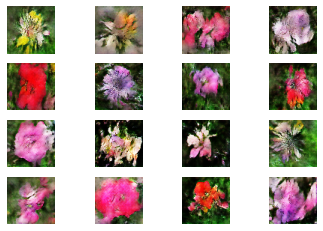

2022-09-16 10:35:31.233057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [461/600], discriminator_loss_for_real_data = 0.002271, discriminator_loss_for_fake_data = 0.000511, generator_loss = 0.022845




2022-09-16 10:36:06.790495: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [462/600], discriminator_loss_for_real_data = 0.002327, discriminator_loss_for_fake_data = 0.000536, generator_loss = 0.022836


epoch -> [463/600], discriminator_loss_for_real_data = 0.002251, discriminator_loss_for_fake_data = 0.000537, generator_loss = 0.022829




2022-09-16 10:37:10.739844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:37:10.826171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:37:11.095054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [464/600], discriminator_loss_for_real_data = 0.002197, discriminator_loss_for_fake_data = 0.000496, generator_loss = 0.022915


epoch -> [465/600], discriminator_loss_for_real_data = 0.002325, discriminator_loss_for_fake_data = 0.000465, generator_loss = 0.022988




2022-09-16 10:37:42.120354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:37:48.547808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [466/600], discriminator_loss_for_real_data = 0.002285, discriminator_loss_for_fake_data = 0.000532, generator_loss = 0.022781




2022-09-16 10:38:13.650719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [467/600], discriminator_loss_for_real_data = 0.002336, discriminator_loss_for_fake_data = 0.000512, generator_loss = 0.022874




2022-09-16 10:38:31.639795: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [468/600], discriminator_loss_for_real_data = 0.002297, discriminator_loss_for_fake_data = 0.000522, generator_loss = 0.022904


epoch -> [469/600], discriminator_loss_for_real_data = 0.002346, discriminator_loss_for_fake_data = 0.000510, generator_loss = 0.022965


epoch -> [470/600], discriminator_loss_for_real_data = 0.002282, discriminator_loss_for_fake_data = 0.000493, generator_loss = 0.022986




2022-09-16 10:39:55.527778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [471/600], discriminator_loss_for_real_data = 0.002198, discriminator_loss_for_fake_data = 0.000519, generator_loss = 0.023004


epoch -> [472/600], discriminator_loss_for_real_data = 0.002170, discriminator_loss_for_fake_data = 0.000472, generator_loss = 0.022936


epoch -> [473/600], discriminator_loss_for_real_data = 0.002349, discriminator_loss_for_fake_data = 0.000531, generator_loss = 0.023109


epoch -> [474/600], discriminator_loss_for_real_data = 0.002384, discriminator_loss_for_fake_data = 0.000460, generator_loss = 0.023029




2022-09-16 10:41:34.670692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [475/600], discriminator_loss_for_real_data = 0.002306, discriminator_loss_for_fake_data = 0.000527, generator_loss = 0.022818


epoch -> [476/600], discriminator_loss_for_real_data = 0.002173, discriminator_loss_for_fake_data = 0.000473, generator_loss = 0.022939


epoch -> [477/600], discriminator_loss_for_real_data = 0.002260, discriminator_loss_for_fake_data = 0.000522, generator_loss = 0.022928


epoch -> [478/600], discriminator_loss_for_real_data = 0.002200, discriminator_loss_for_fake_data = 0.000516, generator_loss = 0.022869


epoch -> [479/600], discriminator_loss_for_real_data = 0.002305, discriminator_loss_for_fake_data = 0.000478, generator_loss = 0.022913


epoch -> [480/600], discriminator_loss_for_real_data = 0.002354, discriminator_loss_for_fake_data = 0.000502, generator_loss = 0.022736


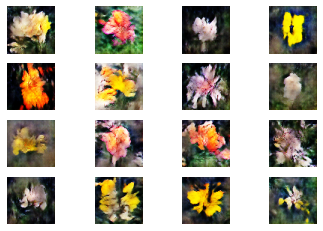



epoch -> [481/600], discriminator_loss_for_real_data = 0.002248, discriminator_loss_for_fake_data = 0.000468, generator_loss = 0.022893




2022-09-16 10:44:30.593415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:44:35.350776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [482/600], discriminator_loss_for_real_data = 0.002208, discriminator_loss_for_fake_data = 0.000557, generator_loss = 0.022828


epoch -> [483/600], discriminator_loss_for_real_data = 0.002285, discriminator_loss_for_fake_data = 0.000457, generator_loss = 0.023021


epoch -> [484/600], discriminator_loss_for_real_data = 0.002261, discriminator_loss_for_fake_data = 0.000464, generator_loss = 0.022884




2022-09-16 10:46:09.907617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [485/600], discriminator_loss_for_real_data = 0.002191, discriminator_loss_for_fake_data = 0.000447, generator_loss = 0.022880


epoch -> [486/600], discriminator_loss_for_real_data = 0.002218, discriminator_loss_for_fake_data = 0.000494, generator_loss = 0.022936




2022-09-16 10:46:42.321917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [487/600], discriminator_loss_for_real_data = 0.002272, discriminator_loss_for_fake_data = 0.000506, generator_loss = 0.023057


epoch -> [488/600], discriminator_loss_for_real_data = 0.002340, discriminator_loss_for_fake_data = 0.000489, generator_loss = 0.022914




2022-09-16 10:47:37.485408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:47:44.783192: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [489/600], discriminator_loss_for_real_data = 0.002241, discriminator_loss_for_fake_data = 0.000474, generator_loss = 0.022795


epoch -> [490/600], discriminator_loss_for_real_data = 0.002198, discriminator_loss_for_fake_data = 0.000472, generator_loss = 0.023040


epoch -> [491/600], discriminator_loss_for_real_data = 0.002299, discriminator_loss_for_fake_data = 0.000472, generator_loss = 0.022844




2022-09-16 10:49:05.635462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [492/600], discriminator_loss_for_real_data = 0.002207, discriminator_loss_for_fake_data = 0.000509, generator_loss = 0.022940


epoch -> [493/600], discriminator_loss_for_real_data = 0.002315, discriminator_loss_for_fake_data = 0.000506, generator_loss = 0.022913


epoch -> [494/600], discriminator_loss_for_real_data = 0.002191, discriminator_loss_for_fake_data = 0.000473, generator_loss = 0.022983




2022-09-16 10:50:23.983810: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [495/600], discriminator_loss_for_real_data = 0.002182, discriminator_loss_for_fake_data = 0.000493, generator_loss = 0.022855




2022-09-16 10:50:33.309877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:50:55.930779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [496/600], discriminator_loss_for_real_data = 0.002264, discriminator_loss_for_fake_data = 0.000492, generator_loss = 0.023048


epoch -> [497/600], discriminator_loss_for_real_data = 0.002186, discriminator_loss_for_fake_data = 0.000504, generator_loss = 0.023014


epoch -> [498/600], discriminator_loss_for_real_data = 0.002291, discriminator_loss_for_fake_data = 0.000445, generator_loss = 0.022971




2022-09-16 10:51:58.561174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [499/600], discriminator_loss_for_real_data = 0.002166, discriminator_loss_for_fake_data = 0.000471, generator_loss = 0.022998


epoch -> [500/600], discriminator_loss_for_real_data = 0.002260, discriminator_loss_for_fake_data = 0.000475, generator_loss = 0.023103


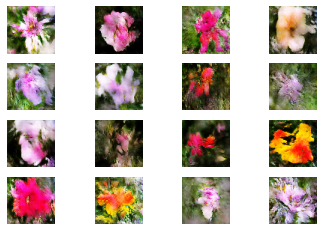



epoch -> [501/600], discriminator_loss_for_real_data = 0.002184, discriminator_loss_for_fake_data = 0.000493, generator_loss = 0.022939


epoch -> [502/600], discriminator_loss_for_real_data = 0.002229, discriminator_loss_for_fake_data = 0.000458, generator_loss = 0.023021




2022-09-16 10:53:33.666998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:53:34.518752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [503/600], discriminator_loss_for_real_data = 0.002250, discriminator_loss_for_fake_data = 0.000494, generator_loss = 0.022927




2022-09-16 10:54:05.499197: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:54:13.198082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [504/600], discriminator_loss_for_real_data = 0.002250, discriminator_loss_for_fake_data = 0.000455, generator_loss = 0.022920


epoch -> [505/600], discriminator_loss_for_real_data = 0.002125, discriminator_loss_for_fake_data = 0.000430, generator_loss = 0.022996


epoch -> [506/600], discriminator_loss_for_real_data = 0.002230, discriminator_loss_for_fake_data = 0.000487, generator_loss = 0.022995




2022-09-16 10:55:19.261339: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [507/600], discriminator_loss_for_real_data = 0.002213, discriminator_loss_for_fake_data = 0.000508, generator_loss = 0.022927


epoch -> [508/600], discriminator_loss_for_real_data = 0.002112, discriminator_loss_for_fake_data = 0.000461, generator_loss = 0.023148




2022-09-16 10:56:12.349084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:56:12.647698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [509/600], discriminator_loss_for_real_data = 0.002192, discriminator_loss_for_fake_data = 0.000478, generator_loss = 0.023069


epoch -> [510/600], discriminator_loss_for_real_data = 0.002181, discriminator_loss_for_fake_data = 0.000496, generator_loss = 0.023036




2022-09-16 10:56:58.653658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [511/600], discriminator_loss_for_real_data = 0.002245, discriminator_loss_for_fake_data = 0.000398, generator_loss = 0.022957




2022-09-16 10:57:47.589660: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [512/600], discriminator_loss_for_real_data = 0.002211, discriminator_loss_for_fake_data = 0.000460, generator_loss = 0.022977




2022-09-16 10:58:04.542358: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [513/600], discriminator_loss_for_real_data = 0.002121, discriminator_loss_for_fake_data = 0.000494, generator_loss = 0.022940


epoch -> [514/600], discriminator_loss_for_real_data = 0.002191, discriminator_loss_for_fake_data = 0.000469, generator_loss = 0.022930


epoch -> [515/600], discriminator_loss_for_real_data = 0.002164, discriminator_loss_for_fake_data = 0.000447, generator_loss = 0.023016




2022-09-16 10:59:22.527231: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:22.978070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:23.141690: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:23.280833: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:23.345643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [516/600], discriminator_loss_for_real_data = 0.002158, discriminator_loss_for_fake_data = 0.000461, generator_loss = 0.022979




2022-09-16 10:59:54.921284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:55.000905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 10:59:55.169803: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [517/600], discriminator_loss_for_real_data = 0.002202, discriminator_loss_for_fake_data = 0.000463, generator_loss = 0.023018


epoch -> [518/600], discriminator_loss_for_real_data = 0.002102, discriminator_loss_for_fake_data = 0.000416, generator_loss = 0.023122


epoch -> [519/600], discriminator_loss_for_real_data = 0.002182, discriminator_loss_for_fake_data = 0.000435, generator_loss = 0.022935


epoch -> [520/600], discriminator_loss_for_real_data = 0.002129, discriminator_loss_for_fake_data = 0.000452, generator_loss = 0.023078


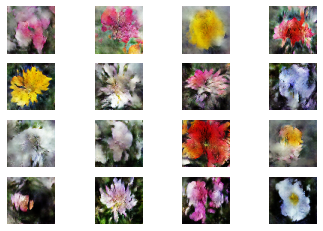

2022-09-16 11:01:22.275882: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [521/600], discriminator_loss_for_real_data = 0.002155, discriminator_loss_for_fake_data = 0.000492, generator_loss = 0.023009


epoch -> [522/600], discriminator_loss_for_real_data = 0.002159, discriminator_loss_for_fake_data = 0.000441, generator_loss = 0.022963


epoch -> [523/600], discriminator_loss_for_real_data = 0.002264, discriminator_loss_for_fake_data = 0.000437, generator_loss = 0.023007


epoch -> [524/600], discriminator_loss_for_real_data = 0.002205, discriminator_loss_for_fake_data = 0.000453, generator_loss = 0.022945




2022-09-16 11:03:04.738128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [525/600], discriminator_loss_for_real_data = 0.002172, discriminator_loss_for_fake_data = 0.000471, generator_loss = 0.022975




2022-09-16 11:03:36.293399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [526/600], discriminator_loss_for_real_data = 0.002279, discriminator_loss_for_fake_data = 0.000443, generator_loss = 0.023021


epoch -> [527/600], discriminator_loss_for_real_data = 0.002105, discriminator_loss_for_fake_data = 0.000472, generator_loss = 0.022933




2022-09-16 11:04:39.627655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:04:39.932818: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:04:40.422010: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [528/600], discriminator_loss_for_real_data = 0.002208, discriminator_loss_for_fake_data = 0.000471, generator_loss = 0.023059


epoch -> [529/600], discriminator_loss_for_real_data = 0.002102, discriminator_loss_for_fake_data = 0.000418, generator_loss = 0.022947




2022-09-16 11:05:11.906953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [530/600], discriminator_loss_for_real_data = 0.002059, discriminator_loss_for_fake_data = 0.000439, generator_loss = 0.023010




2022-09-16 11:05:57.362139: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:05:57.616084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [531/600], discriminator_loss_for_real_data = 0.002114, discriminator_loss_for_fake_data = 0.000453, generator_loss = 0.023128


epoch -> [532/600], discriminator_loss_for_real_data = 0.002113, discriminator_loss_for_fake_data = 0.000454, generator_loss = 0.023145


epoch -> [533/600], discriminator_loss_for_real_data = 0.002204, discriminator_loss_for_fake_data = 0.000462, generator_loss = 0.023013


epoch -> [534/600], discriminator_loss_for_real_data = 0.002129, discriminator_loss_for_fake_data = 0.000389, generator_loss = 0.023139




2022-09-16 11:07:18.401039: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [535/600], discriminator_loss_for_real_data = 0.002239, discriminator_loss_for_fake_data = 0.000440, generator_loss = 0.023015


epoch -> [536/600], discriminator_loss_for_real_data = 0.002113, discriminator_loss_for_fake_data = 0.000442, generator_loss = 0.022982


epoch -> [537/600], discriminator_loss_for_real_data = 0.002138, discriminator_loss_for_fake_data = 0.000462, generator_loss = 0.022982




2022-09-16 11:08:53.124057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:08:53.670805: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [538/600], discriminator_loss_for_real_data = 0.002130, discriminator_loss_for_fake_data = 0.000433, generator_loss = 0.023126


epoch -> [539/600], discriminator_loss_for_real_data = 0.002032, discriminator_loss_for_fake_data = 0.000442, generator_loss = 0.023136


epoch -> [540/600], discriminator_loss_for_real_data = 0.002127, discriminator_loss_for_fake_data = 0.000429, generator_loss = 0.023092


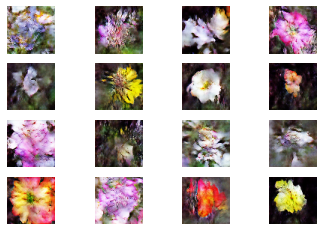

2022-09-16 11:10:10.613808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [541/600], discriminator_loss_for_real_data = 0.002133, discriminator_loss_for_fake_data = 0.000425, generator_loss = 0.023011




2022-09-16 11:10:21.289179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [542/600], discriminator_loss_for_real_data = 0.002114, discriminator_loss_for_fake_data = 0.000414, generator_loss = 0.023300




2022-09-16 11:11:00.312979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:11:01.251611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [543/600], discriminator_loss_for_real_data = 0.002078, discriminator_loss_for_fake_data = 0.000412, generator_loss = 0.023099


epoch -> [544/600], discriminator_loss_for_real_data = 0.002074, discriminator_loss_for_fake_data = 0.000448, generator_loss = 0.022994


epoch -> [545/600], discriminator_loss_for_real_data = 0.002195, discriminator_loss_for_fake_data = 0.000454, generator_loss = 0.022950




2022-09-16 11:12:03.765415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:12:04.529767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [546/600], discriminator_loss_for_real_data = 0.002101, discriminator_loss_for_fake_data = 0.000406, generator_loss = 0.023223




2022-09-16 11:12:36.393791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [547/600], discriminator_loss_for_real_data = 0.002097, discriminator_loss_for_fake_data = 0.000434, generator_loss = 0.023078


epoch -> [548/600], discriminator_loss_for_real_data = 0.002192, discriminator_loss_for_fake_data = 0.000440, generator_loss = 0.022971




2022-09-16 11:13:38.926106: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [549/600], discriminator_loss_for_real_data = 0.002090, discriminator_loss_for_fake_data = 0.000437, generator_loss = 0.023003


epoch -> [550/600], discriminator_loss_for_real_data = 0.002183, discriminator_loss_for_fake_data = 0.000430, generator_loss = 0.023064


epoch -> [551/600], discriminator_loss_for_real_data = 0.002107, discriminator_loss_for_fake_data = 0.000419, generator_loss = 0.023019


epoch -> [552/600], discriminator_loss_for_real_data = 0.002052, discriminator_loss_for_fake_data = 0.000445, generator_loss = 0.022914




2022-09-16 11:15:14.105031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:15:14.273927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [553/600], discriminator_loss_for_real_data = 0.002037, discriminator_loss_for_fake_data = 0.000441, generator_loss = 0.023120




2022-09-16 11:15:45.677246: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [554/600], discriminator_loss_for_real_data = 0.002102, discriminator_loss_for_fake_data = 0.000392, generator_loss = 0.023092




2022-09-16 11:16:17.653098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [555/600], discriminator_loss_for_real_data = 0.002074, discriminator_loss_for_fake_data = 0.000420, generator_loss = 0.023192


epoch -> [556/600], discriminator_loss_for_real_data = 0.002046, discriminator_loss_for_fake_data = 0.000436, generator_loss = 0.023145




2022-09-16 11:16:57.304263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:16:57.496779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [557/600], discriminator_loss_for_real_data = 0.002133, discriminator_loss_for_fake_data = 0.000403, generator_loss = 0.023028




2022-09-16 11:17:19.147240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [558/600], discriminator_loss_for_real_data = 0.002098, discriminator_loss_for_fake_data = 0.000410, generator_loss = 0.023024




2022-09-16 11:17:53.339601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [559/600], discriminator_loss_for_real_data = 0.002058, discriminator_loss_for_fake_data = 0.000414, generator_loss = 0.023014




2022-09-16 11:18:25.051839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [560/600], discriminator_loss_for_real_data = 0.002134, discriminator_loss_for_fake_data = 0.000420, generator_loss = 0.023012


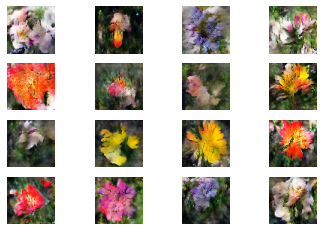



epoch -> [561/600], discriminator_loss_for_real_data = 0.002049, discriminator_loss_for_fake_data = 0.000381, generator_loss = 0.023058


epoch -> [562/600], discriminator_loss_for_real_data = 0.002065, discriminator_loss_for_fake_data = 0.000439, generator_loss = 0.023229




2022-09-16 11:19:28.621559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [563/600], discriminator_loss_for_real_data = 0.002097, discriminator_loss_for_fake_data = 0.000415, generator_loss = 0.023088




2022-09-16 11:19:59.411225: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:20:04.526404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [564/600], discriminator_loss_for_real_data = 0.002111, discriminator_loss_for_fake_data = 0.000452, generator_loss = 0.023115


epoch -> [565/600], discriminator_loss_for_real_data = 0.002065, discriminator_loss_for_fake_data = 0.000392, generator_loss = 0.023174


epoch -> [566/600], discriminator_loss_for_real_data = 0.002004, discriminator_loss_for_fake_data = 0.000399, generator_loss = 0.023268


epoch -> [567/600], discriminator_loss_for_real_data = 0.002165, discriminator_loss_for_fake_data = 0.000420, generator_loss = 0.023148


epoch -> [568/600], discriminator_loss_for_real_data = 0.002054, discriminator_loss_for_fake_data = 0.000418, generator_loss = 0.023214


epoch -> [569/600], discriminator_loss_for_real_data = 0.002000, discriminator_loss_for_fake_data = 0.000419, generator_loss = 0.023242




2022-09-16 11:22:38.403811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [570/600], discriminator_loss_for_real_data = 0.002084, discriminator_loss_for_fake_data = 0.000411, generator_loss = 0.023187


epoch -> [571/600], discriminator_loss_for_real_data = 0.002101, discriminator_loss_for_fake_data = 0.000448, generator_loss = 0.023070




2022-09-16 11:23:33.177438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [572/600], discriminator_loss_for_real_data = 0.002061, discriminator_loss_for_fake_data = 0.000382, generator_loss = 0.023168




2022-09-16 11:23:41.655187: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:23:42.043798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [573/600], discriminator_loss_for_real_data = 0.002033, discriminator_loss_for_fake_data = 0.000447, generator_loss = 0.023114


epoch -> [574/600], discriminator_loss_for_real_data = 0.002090, discriminator_loss_for_fake_data = 0.000392, generator_loss = 0.023103




2022-09-16 11:24:45.139228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [575/600], discriminator_loss_for_real_data = 0.002072, discriminator_loss_for_fake_data = 0.000406, generator_loss = 0.023224


epoch -> [576/600], discriminator_loss_for_real_data = 0.001962, discriminator_loss_for_fake_data = 0.000401, generator_loss = 0.023240


epoch -> [577/600], discriminator_loss_for_real_data = 0.001985, discriminator_loss_for_fake_data = 0.000387, generator_loss = 0.023266


epoch -> [578/600], discriminator_loss_for_real_data = 0.002044, discriminator_loss_for_fake_data = 0.000398, generator_loss = 0.023069


epoch -> [579/600], discriminator_loss_for_real_data = 0.002014, discriminator_loss_for_fake_data = 0.000417, generator_loss = 0.023217


epoch -> [580/600], discriminator_loss_for_real_data = 0.001987, discriminator_loss_for_fake_data = 0.000393, generator_loss = 0.023114


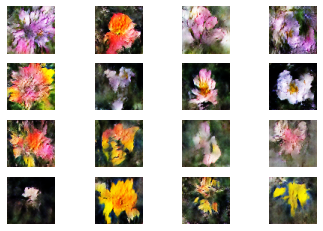

2022-09-16 11:27:24.489973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:27:24.644702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:27:24.728784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [581/600], discriminator_loss_for_real_data = 0.002043, discriminator_loss_for_fake_data = 0.000404, generator_loss = 0.023208




2022-09-16 11:27:46.377962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [582/600], discriminator_loss_for_real_data = 0.002060, discriminator_loss_for_fake_data = 0.000350, generator_loss = 0.023233




2022-09-16 11:28:08.299700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:28:08.396543: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [583/600], discriminator_loss_for_real_data = 0.002124, discriminator_loss_for_fake_data = 0.000419, generator_loss = 0.023066




2022-09-16 11:28:27.749029: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:28:27.826777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [584/600], discriminator_loss_for_real_data = 0.002089, discriminator_loss_for_fake_data = 0.000411, generator_loss = 0.023115




2022-09-16 11:28:59.614707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:28:59.759897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:29:14.211466: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [585/600], discriminator_loss_for_real_data = 0.002029, discriminator_loss_for_fake_data = 0.000375, generator_loss = 0.023265


epoch -> [586/600], discriminator_loss_for_real_data = 0.002000, discriminator_loss_for_fake_data = 0.000412, generator_loss = 0.023199




2022-09-16 11:30:02.442347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [587/600], discriminator_loss_for_real_data = 0.002086, discriminator_loss_for_fake_data = 0.000423, generator_loss = 0.023084


epoch -> [588/600], discriminator_loss_for_real_data = 0.001982, discriminator_loss_for_fake_data = 0.000355, generator_loss = 0.023226




2022-09-16 11:30:34.388082: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [589/600], discriminator_loss_for_real_data = 0.002011, discriminator_loss_for_fake_data = 0.000407, generator_loss = 0.023100


epoch -> [590/600], discriminator_loss_for_real_data = 0.002025, discriminator_loss_for_fake_data = 0.000394, generator_loss = 0.023183


epoch -> [591/600], discriminator_loss_for_real_data = 0.002084, discriminator_loss_for_fake_data = 0.000344, generator_loss = 0.023368




2022-09-16 11:32:10.344666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [592/600], discriminator_loss_for_real_data = 0.001944, discriminator_loss_for_fake_data = 0.000433, generator_loss = 0.023180




2022-09-16 11:32:41.974149: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-09-16 11:32:42.049019: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [593/600], discriminator_loss_for_real_data = 0.002060, discriminator_loss_for_fake_data = 0.000396, generator_loss = 0.023202


epoch -> [594/600], discriminator_loss_for_real_data = 0.001964, discriminator_loss_for_fake_data = 0.000380, generator_loss = 0.023153




2022-09-16 11:33:12.829892: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [595/600], discriminator_loss_for_real_data = 0.001932, discriminator_loss_for_fake_data = 0.000394, generator_loss = 0.023231




2022-09-16 11:33:44.512895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [596/600], discriminator_loss_for_real_data = 0.001998, discriminator_loss_for_fake_data = 0.000419, generator_loss = 0.023261




2022-09-16 11:34:16.700941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [597/600], discriminator_loss_for_real_data = 0.002070, discriminator_loss_for_fake_data = 0.000382, generator_loss = 0.023246


epoch -> [598/600], discriminator_loss_for_real_data = 0.002013, discriminator_loss_for_fake_data = 0.000349, generator_loss = 0.023238




2022-09-16 11:34:52.515778: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


epoch -> [599/600], discriminator_loss_for_real_data = 0.002009, discriminator_loss_for_fake_data = 0.000404, generator_loss = 0.023183


epoch -> [600/600], discriminator_loss_for_real_data = 0.002003, discriminator_loss_for_fake_data = 0.000373, generator_loss = 0.023240


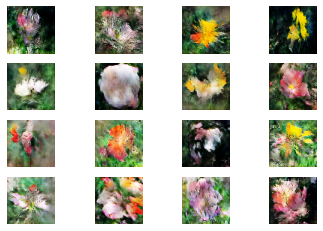

In [53]:
with tf.device(device_name):

  latent_dim = 512
  n_epochs = 600
  n_batch = 40
  d_model = define_discriminator()
  g_model = define_generator(latent_dim)
  gan_model = define_gan(g_model, d_model)
  dataset = load_real_samples()
  print('\nREADY TO GO !!!\n')
  
  d_loss_real_array, d_loss_fake_array, g_loss_array = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

## Plot Loss Values

In [54]:
# g_model.save("/content/sample_data/generator_model_c_dcgan.h5")

In [55]:
# loaded = np.load('/content/drive/MyDrive/GAN_New_Approch/4/loss_record_4.npz')
# print(loaded['a'].shape)
# print(loaded['b'].shape)

In [56]:
import matplotlib.pyplot as plot

# d_loss = np.array(loaded['a'])
# g_loss = np.array(loaded['b'])

In [57]:
d_loss = np.array([(i+j) for i,j in zip(d_loss_real_array, d_loss_fake_array)])

In [58]:
g_loss = g_loss_array

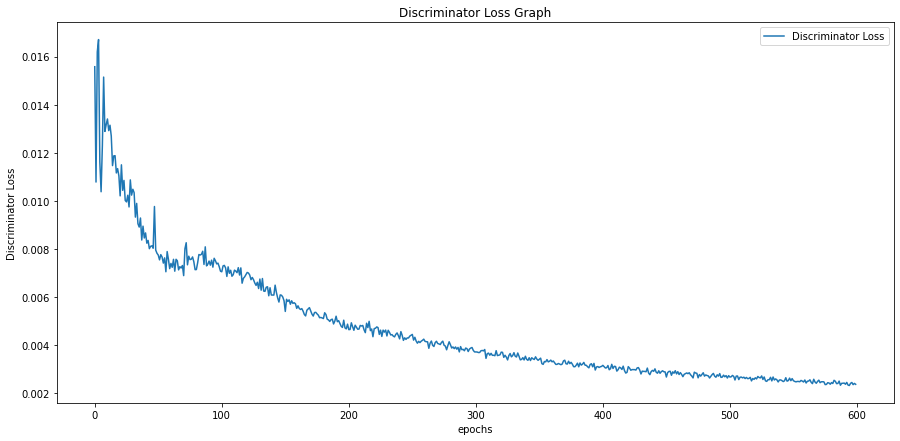

In [59]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.title('Discriminator Loss Graph')
plt.ylabel('Discriminator Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss"], loc='upper right')
plt.savefig("Discriminator_Loss_Graph")
plt.show()

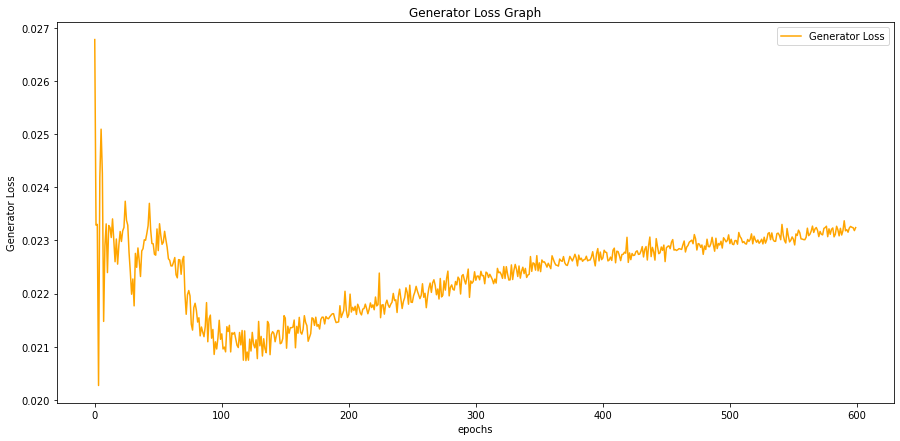

In [60]:
plt.figure(figsize=(15,7))
plt.plot(g_loss,color='orange')
plt.title('Generator Loss Graph')
plt.ylabel('Generator Loss')
plt.xlabel('epochs')
plt.legend(["Generator Loss"], loc='upper right')
plt.savefig("Generator_Loss_Graph")
plt.show()

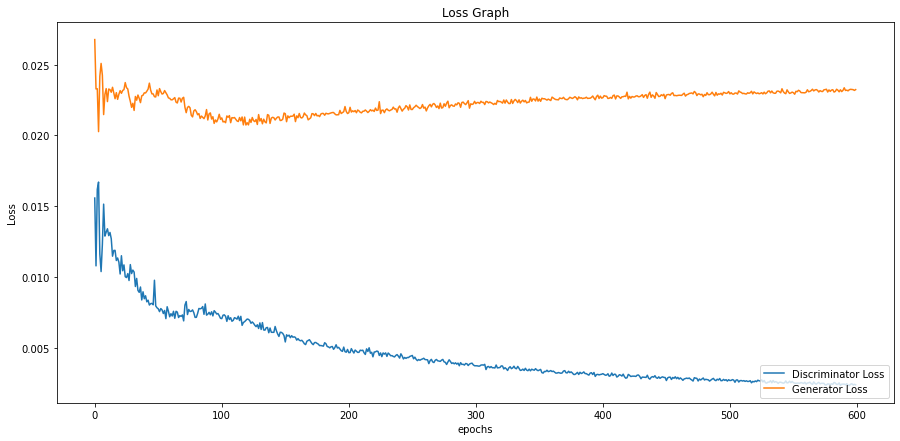

In [61]:
plt.figure(figsize=(15,7))
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Loss Graph')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(["Discriminator Loss", "Generator Loss"], loc='lower right')
plt.savefig("Loss_Graph")
plt.show()

# Prediction

In [62]:
# generator = tensorflow.keras.models.load_model("/content/drive/MyDrive/GAN_New_Approch/4/generator_model_4.h5")

In [63]:
# latent_dim = 512
# n_samples = 16
# z_input, labels = generate_latent_points(latent_dim, n_samples)
# print("latent points(latent points and labels): ",z_input.shape, labels.shape)
# data = [z_input,labels]
# pred = generator.predict(data)
# # pred = (pred +1 ) / 2.0
# print("\nGenerated images with labels: ",pred.shape,'\n')
# save_plot(pred,n=4)

                                              -:END:-